In [ ]:
import pickle
import numpy as np
import glob
import matplotlib.pyplot as plt
from Noiseprint import *
import os
from torchvision import transforms
from PIL import Image
from timeit import default_timer as timer


In [ ]:
# model = torch.load("C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\Forged_Aadhaar\\forged_aadhaar_detection.pth", weights_only=False)
# model.eval()
model = torch.jit.load("detection_model.pt", map_location=torch.device("cpu"))


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Your original noiseprint generation code
examples = []
noiseprints = []

for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\temp\\*'):
    example, noise_print = getNoiseprint(img_path)
    examples.append(example)
    print(img_path.split('\\')[-1].split('.')[0])
    noiseprints.append([img_path.split('\\')[-1].split('.')[0], noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprints_folder"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Function to enhance contrast and brightness
def enhance_noiseprint(img, method='clahe'):
    """
    Enhance noiseprint visibility using various methods
    
    Parameters:
    - img: normalized image (0-1 range)
    - method: 'clahe', 'histogram_eq', 'gamma', or 'adaptive'
    """
    # Convert to 8-bit for processing
    img_8bit = (img * 255).astype(np.uint8)
    
    if method == 'clahe':
        # CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(img_8bit)
    
    elif method == 'histogram_eq':
        # Standard histogram equalization
        enhanced = cv2.equalizeHist(img_8bit)
    
    elif method == 'gamma':
        # Gamma correction (gamma < 1 brightens, gamma > 1 darkens)
        gamma = 0.5
        enhanced = np.power(img, gamma)
        return enhanced
    
    elif method == 'adaptive':
        # Adaptive thresholding with brightness boost
        enhanced = cv2.adaptiveThreshold(img_8bit, 255, 
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY, 11, 2)
    
    # Convert back to 0-1 range
    return enhanced / 255.0

# Save multiple versions of each noiseprint
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res
    
    # Normalize
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)
    
    # Save original
    filename_orig = os.path.join(output_dir, f"noiseprint_{name}_original.png")
    plt.imsave(filename_orig, norm_crop, cmap='gray')
    
    # Save CLAHE enhanced version (best for noiseprints)
    enhanced_clahe = enhance_noiseprint(norm_crop, method='clahe')
    filename_clahe = os.path.join(output_dir, f"noiseprint_{name}_clahe.png")
    plt.imsave(filename_clahe, enhanced_clahe, cmap='gray')
    
    # Save histogram equalized version
    enhanced_hist = enhance_noiseprint(norm_crop, method='histogram_eq')
    filename_hist = os.path.join(output_dir, f"noiseprint_{name}_hist_eq.png")
    plt.imsave(filename_hist, enhanced_hist, cmap='gray')
    
    # Save gamma corrected version (brightened)
    enhanced_gamma = enhance_noiseprint(norm_crop, method='gamma')
    filename_gamma = os.path.join(output_dir, f"noiseprint_{name}_gamma.png")
    plt.imsave(filename_gamma, enhanced_gamma, cmap='gray')
    
    # Optional: Create a comparison image showing all versions
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(norm_crop, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(enhanced_clahe, cmap='gray')
    axes[1].set_title('CLAHE Enhanced')
    axes[1].axis('off')
    
    axes[2].imshow(enhanced_hist, cmap='gray')
    axes[2].set_title('Histogram Equalized')
    axes[2].axis('off')
    
    axes[3].imshow(enhanced_gamma, cmap='gray')
    axes[3].set_title('Gamma Corrected')
    axes[3].axis('off')
    
    plt.tight_layout()
    comparison_file = os.path.join(output_dir, f"noiseprint_{name}_comparison.png")
    plt.savefig(comparison_file, dpi=150, bbox_inches='tight')
    plt.close()

print(f"Enhanced noiseprints saved to {output_dir}")
print("Multiple versions created: CLAHE, Histogram Equalization, Gamma Correction, and Comparison")

In [ ]:
examples=[]
noiseprints=[]

for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\tempfolder\\*'):
     example,noise_print=getNoiseprint(img_path)
     examples.append(example)
     print(img_path.split('\\')[-1].split('.')[0])
     noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprints_folder"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Save cropped and normalized noiseprints
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
from sklearn.cluster import DBSCAN
import warnings

warnings.filterwarnings('ignore')

diff_output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprint_diff_highlight"
os.makedirs(diff_output_dir, exist_ok=True)

# ============================================================================
# STEP 1: CHECK AND FIX NOISEPRINTS DATA
# ============================================================================

print("\n" + "="*70)
print("CHECKING NOISEPRINT DATA")
print("="*70 + "\n")

# Check if noiseprints variable exists and what it contains
try:
    print(f"Number of items in noiseprints: {len(noiseprints)}")
    print(f"\nFirst few items:")
    for i, (name, res) in enumerate(noiseprints[:3]):
        print(f"  {i+1}. Name: {name}")
        print(f"     Type: {type(res)}")
        print(f"     Shape: {res.shape if hasattr(res, 'shape') else 'N/A'}")
        print(f"     Data type: {res.dtype if hasattr(res, 'dtype') else 'N/A'}")
        if hasattr(res, 'shape') and res.size > 0:
            print(f"     Value range: [{np.min(res):.4f}, {np.max(res):.4f}]")
        print()
except NameError:
    print("❌ ERROR: 'noiseprints' variable not found!")
    print("Please make sure you've run the noiseprint extraction code first.")
    print("\nExpected format:")
    print("  noiseprints = [(name1, array1), (name2, array2), ...]")
    exit(1)

# ============================================================================
# STEP 2: LOAD NOISEPRINTS FROM SAVED FILES IF NEEDED
# ============================================================================

def load_noiseprints_from_directory(noiseprint_dir):
    """
    Load noiseprints from saved .npy files
    """
    noiseprint_files = glob.glob(os.path.join(noiseprint_dir, "*.npy"))
    loaded_noiseprints = []
    
    print(f"\nFound {len(noiseprint_files)} .npy files")
    
    for npy_path in noiseprint_files:
        try:
            name = os.path.splitext(os.path.basename(npy_path))[0]
            noiseprint = np.load(npy_path)
            loaded_noiseprints.append((name, noiseprint))
            print(f"  ✓ Loaded: {name} - Shape: {noiseprint.shape}")
        except Exception as e:
            print(f"  ❌ Failed to load {npy_path}: {e}")
    
    return loaded_noiseprints

# Try to load from directory if noiseprints are empty
if all(res.size == 0 for _, res in noiseprints):
    print("\n⚠️  All noiseprints are empty! Attempting to load from saved files...")
    
    # Common noiseprint output directories - update these paths as needed
    possible_dirs = [
        "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprints",
        "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprint_output",
        "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\noiseprints",
        "./noiseprints",
        "./output/noiseprints"
    ]
    
    loaded = False
    for directory in possible_dirs:
        if os.path.exists(directory):
            print(f"\n📁 Checking directory: {directory}")
            temp_noiseprints = load_noiseprints_from_directory(directory)
            if temp_noiseprints:
                noiseprints = temp_noiseprints
                loaded = True
                print(f"\n✅ Successfully loaded {len(noiseprints)} noiseprints!")
                break
    
    if not loaded:
        print("\n❌ Could not find saved noiseprints!")
        print("Please provide the directory path where noiseprints are saved:")
        print("Or re-run the noiseprint extraction code first.")
        exit(1)

# ============================================================================
# ANALYSIS FUNCTIONS
# ============================================================================

def analyze_numpy_values(noise_crop):
    """
    Analyze numpy values to detect distortions using statistical methods
    """
    # Check if noise_crop is empty or too small
    if noise_crop.size == 0:
        return None, None
    
    if noise_crop.shape[0] < 10 or noise_crop.shape[1] < 10:
        return None, None
    
    # Check for NaN or Inf values
    if np.any(np.isnan(noise_crop)) or np.any(np.isinf(noise_crop)):
        noise_crop = np.nan_to_num(noise_crop, nan=0.0, posinf=0.0, neginf=0.0)
    
    try:
        # Method 1: Z-score based anomaly detection
        mean_val = np.mean(noise_crop)
        std_val = np.std(noise_crop)
        
        if std_val == 0:
            z_mask = np.zeros_like(noise_crop, dtype=np.uint8)
        else:
            z_scores = np.abs((noise_crop - mean_val) / std_val)
            z_mask = (z_scores > 2.5).astype(np.uint8) * 255
        
        # Method 2: Percentile-based detection
        try:
            lower_percentile = np.percentile(noise_crop, 5)
            upper_percentile = np.percentile(noise_crop, 95)
            percentile_mask = ((noise_crop < lower_percentile) | (noise_crop > upper_percentile)).astype(np.uint8) * 255
        except:
            percentile_mask = np.zeros_like(noise_crop, dtype=np.uint8)
        
        # Method 3: Local variance analysis
        kernel_size = min(15, noise_crop.shape[0] // 4, noise_crop.shape[1] // 4)
        if kernel_size < 3:
            kernel_size = 3
        
        try:
            mean_filter = cv2.blur(noise_crop.astype(np.float32), (kernel_size, kernel_size))
            sqr_filter = cv2.blur((noise_crop ** 2).astype(np.float32), (kernel_size, kernel_size))
            variance_map = np.abs(sqr_filter - mean_filter ** 2)
            
            variance_norm = cv2.normalize(variance_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            _, variance_mask = cv2.threshold(variance_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        except:
            variance_mask = np.zeros_like(noise_crop, dtype=np.uint8)
        
        # Method 4: Gradient magnitude analysis
        try:
            grad_x = cv2.Sobel(noise_crop.astype(np.float32), cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(noise_crop.astype(np.float32), cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
            
            grad_norm = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            _, gradient_mask = cv2.threshold(grad_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        except:
            gradient_mask = np.zeros_like(noise_crop, dtype=np.uint8)
        
        # Method 5: Texture consistency
        def calculate_local_entropy_fast(img, window_size=15):
            try:
                kernel = np.ones((window_size, window_size), np.float32) / (window_size ** 2)
                mean = cv2.filter2D(img.astype(np.float32), -1, kernel)
                mean_sq = cv2.filter2D((img ** 2).astype(np.float32), -1, kernel)
                variance = np.abs(mean_sq - mean ** 2)
                entropy_approx = np.sqrt(variance)
                return entropy_approx
            except:
                return np.zeros_like(img, dtype=np.float32)
        
        entropy_map = calculate_local_entropy_fast(noise_crop)
        entropy_norm = cv2.normalize(entropy_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, entropy_mask = cv2.threshold(entropy_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Combine all methods
        combined_mask = (
            z_mask.astype(np.float32) * 0.25 +
            percentile_mask.astype(np.float32) * 0.15 +
            variance_mask.astype(np.float32) * 0.25 +
            gradient_mask.astype(np.float32) * 0.20 +
            entropy_mask.astype(np.float32) * 0.15
        )
        
        combined_mask = cv2.normalize(combined_mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, final_mask = cv2.threshold(combined_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Calculate statistics
        try:
            skewness = stats.skew(noise_crop.flatten())
            kurtosis = stats.kurtosis(noise_crop.flatten())
        except:
            skewness = 0.0
            kurtosis = 0.0
        
        return final_mask, {
            'z_score_mask': z_mask,
            'percentile_mask': percentile_mask,
            'variance_mask': variance_mask,
            'gradient_mask': gradient_mask,
            'entropy_mask': entropy_mask,
            'combined_mask': combined_mask,
            'statistics': {
                'mean': float(mean_val),
                'std': float(std_val),
                'min': float(np.min(noise_crop)),
                'max': float(np.max(noise_crop)),
                'median': float(np.median(noise_crop)),
                'skewness': float(skewness),
                'kurtosis': float(kurtosis)
            }
        }
    
    except Exception as e:
        print(f"  ❌ Error in analysis: {e}")
        return None, None

def detect_distortion_clusters(noise_crop, mask):
    """Use clustering to identify distinct distorted regions"""
    if mask is None or np.sum(mask) == 0:
        return np.zeros_like(noise_crop, dtype=np.uint8)
    
    try:
        coords = np.column_stack(np.where(mask > 0))
        
        if len(coords) < 10:
            return mask
        
        clustering = DBSCAN(eps=20, min_samples=50).fit(coords)
        labels = clustering.labels_
        
        refined_mask = np.zeros_like(mask)
        unique_labels = set(labels)
        
        for label in unique_labels:
            if label == -1:
                continue
            
            cluster_coords = coords[labels == label]
            if len(cluster_coords) > 500:
                refined_mask[cluster_coords[:, 0], cluster_coords[:, 1]] = 255
        
        return refined_mask
    
    except:
        return mask

def create_comprehensive_visualization(name, orig_img, noise_crop, masks, statistics, output_dir):
    """Create comprehensive visualization"""
    try:
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle(f'Distortion Analysis: {name}', fontsize=16, fontweight='bold')
        
        # Row 1
        axes[0, 0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('Original Image', fontweight='bold')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(noise_crop, cmap='gray')
        axes[0, 1].set_title('Noiseprint', fontweight='bold')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(masks['z_score_mask'], cmap='hot')
        axes[0, 2].set_title('Z-Score Anomalies', fontweight='bold')
        axes[0, 2].axis('off')
        
        axes[0, 3].imshow(masks['percentile_mask'], cmap='hot')
        axes[0, 3].set_title('Percentile Outliers', fontweight='bold')
        axes[0, 3].axis('off')
        
        # Row 2
        axes[1, 0].imshow(masks['variance_mask'], cmap='hot')
        axes[1, 0].set_title('Variance Analysis', fontweight='bold')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(masks['gradient_mask'], cmap='hot')
        axes[1, 1].set_title('Gradient Anomalies', fontweight='bold')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(masks['entropy_mask'], cmap='hot')
        axes[1, 2].set_title('Entropy Analysis', fontweight='bold')
        axes[1, 2].axis('off')
        
        axes[1, 3].imshow(masks['combined_mask'], cmap='hot')
        axes[1, 3].set_title('Combined Detection', fontweight='bold')
        axes[1, 3].axis('off')
        
        # Row 3
        mask_resized = cv2.resize(masks['combined_mask'], (orig_img.shape[1], orig_img.shape[0]))
        overlay = orig_img.copy()
        overlay[mask_resized > 128] = [0, 255, 0]
        axes[2, 0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axes[2, 0].set_title('Detection Overlay', fontweight='bold')
        axes[2, 0].axis('off')
        
        heatmap = cv2.applyColorMap(masks['combined_mask'], cv2.COLORMAP_JET)
        heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
        heatmap_overlay = cv2.addWeighted(orig_img, 0.7, heatmap_resized, 0.3, 0)
        axes[2, 1].imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
        axes[2, 1].set_title('Heatmap Overlay', fontweight='bold')
        axes[2, 1].axis('off')
        
        stats_text = f"""Statistical Analysis:

Mean:      {statistics['mean']:.4f}
Std Dev:   {statistics['std']:.4f}
Min:       {statistics['min']:.4f}
Max:       {statistics['max']:.4f}
Median:    {statistics['median']:.4f}
Skewness:  {statistics['skewness']:.4f}
Kurtosis:  {statistics['kurtosis']:.4f}"""
        
        axes[2, 2].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center', 
                       family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[2, 2].axis('off')
        axes[2, 2].set_title('Statistics', fontweight='bold')
        
        axes[2, 3].hist(noise_crop.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[2, 3].axvline(statistics['mean'], color='red', linestyle='--', linewidth=2, label='Mean')
        axes[2, 3].axvline(statistics['median'], color='green', linestyle='--', linewidth=2, label='Median')
        axes[2, 3].set_title('Value Distribution', fontweight='bold')
        axes[2, 3].legend()
        axes[2, 3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        save_path = os.path.join(output_dir, f"comprehensive_analysis_{name}.png")
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        return True
        
    except Exception as e:
        print(f"  ⚠️  Visualization failed: {e}")
        plt.close('all')
        return False

# ============================================================================
# MAIN PROCESSING LOOP
# ============================================================================

border = 0
image_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\tempfolder"

print("\n" + "="*70)
print("ADVANCED NOISEPRINT DISTORTION DETECTION")
print("="*70 + "\n")

successful_processing = 0
failed_processing = 0
skipped_processing = 0

for idx, (name, res) in enumerate(noiseprints, 1):
    print(f"\n{'─'*70}")
    print(f"📄 [{idx}/{len(noiseprints)}] Processing: {name}")
    print(f"{'─'*70}")
    
    try:
        # Crop
        if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
            noise_crop = res[border:-border, border:-border]
        else:
            noise_crop = res
        
        print(f"  📏 Noiseprint shape: {noise_crop.shape}")
        
        # Skip if too small
        if noise_crop.size == 0 or noise_crop.shape[0] < 10 or noise_crop.shape[1] < 10:
            print(f"  ⚠️  Noiseprint too small or empty, skipping...")
            skipped_processing += 1
            continue
        
        # Numpy analysis
        print("  🔍 Analyzing with multiple methods...")
        numpy_mask, analysis_results = analyze_numpy_values(noise_crop)
        
        if numpy_mask is None:
            print(f"  ⚠️  Analysis failed, using fallback method...")
            numpy_mask = np.zeros_like(noise_crop, dtype=np.uint8)
            clustered_mask = np.zeros_like(noise_crop, dtype=np.uint8)
        else:
            print("  🎯 Refining detections...")
            clustered_mask = detect_distortion_clusters(noise_crop, numpy_mask)
        
        # Original method
        local_mean = cv2.GaussianBlur(noise_crop.astype(np.float32), (15, 15), 0)
        diff_map = np.abs(noise_crop - local_mean)
        diff_norm = cv2.normalize(diff_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        diff_thresh = cv2.adaptiveThreshold(diff_norm, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)
        
        kernel = np.ones((5, 5), np.uint8)
        diff_clean = cv2.morphologyEx(diff_thresh, cv2.MORPH_OPEN, kernel)
        diff_clean = cv2.morphologyEx(diff_clean, cv2.MORPH_DILATE, kernel)
        
        # Combine methods
        target_shape = (diff_clean.shape[1], diff_clean.shape[0])
        numpy_mask_resized = cv2.resize(numpy_mask, target_shape, interpolation=cv2.INTER_NEAREST)
        clustered_mask_resized = cv2.resize(clustered_mask, target_shape, interpolation=cv2.INTER_NEAREST)
        
        final_combined_mask = (
            diff_clean.astype(np.float32) * 0.4 +
            numpy_mask_resized.astype(np.float32) * 0.4 +
            clustered_mask_resized.astype(np.float32) * 0.2
        )
        
        final_combined_mask = cv2.normalize(final_combined_mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, final_combined_mask = cv2.threshold(final_combined_mask, 127, 255, cv2.THRESH_BINARY)
        
        kernel_final = np.ones((7, 7), np.uint8)
        final_combined_mask = cv2.morphologyEx(final_combined_mask, cv2.MORPH_CLOSE, kernel_final)
        final_combined_mask = cv2.morphologyEx(final_combined_mask, cv2.MORPH_OPEN, kernel_final)
        
        # Load original image
        image_lookup = {}
        for img_path in glob.glob(os.path.join(image_dir, "*")):
            base = os.path.splitext(os.path.basename(img_path))[0]
            image_lookup[base] = img_path
        
        orig_img_path = image_lookup.get(name)
        
        if orig_img_path is None or not os.path.exists(orig_img_path):
            print(f"  ❌ Original image not found for {name}")
            failed_processing += 1
            continue
        
        orig_img = cv2.imread(orig_img_path)
        
        if orig_img is None:
            print(f"  ❌ Could not load image")
            failed_processing += 1
            continue
        
        # Create visualizations
        if analysis_results is not None:
            analysis_results['combined_mask'] = final_combined_mask
            create_comprehensive_visualization(name, orig_img, noise_crop, analysis_results, 
                                             analysis_results['statistics'], diff_output_dir)
        
        # Save outputs
        heatmap = cv2.applyColorMap(final_combined_mask, cv2.COLORMAP_JET)
        heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
        overlay = cv2.addWeighted(orig_img, 0.75, heatmap, 0.25, 0)
        
        cv2.imwrite(os.path.join(diff_output_dir, f"diff_highlight_{name}.png"), overlay)
        
        mask_resized = cv2.resize(final_combined_mask, (orig_img.shape[1], orig_img.shape[0]), 
                                 interpolation=cv2.INTER_NEAREST)
        binary_mask = mask_resized > 0
        
        forged_only = np.zeros_like(orig_img)
        forged_only[binary_mask] = orig_img[binary_mask]
        cv2.imwrite(os.path.join(diff_output_dir, f"forged_regions_only_{name}.png"), forged_only)
        
        alpha = np.zeros((orig_img.shape[0], orig_img.shape[1]), dtype=np.uint8)
        alpha[binary_mask] = 255
        forged_rgba = np.dstack([orig_img, alpha])
        cv2.imwrite(os.path.join(diff_output_dir, f"forged_regions_transparent_{name}.png"), forged_rgba)
        
        # Save method results
        if analysis_results is not None:
            methods_dir = os.path.join(diff_output_dir, f"{name}_methods")
            os.makedirs(methods_dir, exist_ok=True)
            
            cv2.imwrite(os.path.join(methods_dir, "z_score.png"), analysis_results['z_score_mask'])
            cv2.imwrite(os.path.join(methods_dir, "percentile.png"), analysis_results['percentile_mask'])
            cv2.imwrite(os.path.join(methods_dir, "variance.png"), analysis_results['variance_mask'])
            cv2.imwrite(os.path.join(methods_dir, "gradient.png"), analysis_results['gradient_mask'])
            cv2.imwrite(os.path.join(methods_dir, "entropy.png"), analysis_results['entropy_mask'])
            cv2.imwrite(os.path.join(methods_dir, "final_combined.png"), final_combined_mask)
        
        # Detection metrics
        num_labels, labels, stats_cc, centroids = cv2.connectedComponentsWithStats(mask_resized, connectivity=8)
        
        print(f"\n  📈 Detection Results:")
        print(f"     Detected regions: {num_labels - 1}")
        print(f"     Forged pixels: {np.sum(binary_mask):,}")
        print(f"     Forged percentage: {(np.sum(binary_mask) / binary_mask.size) * 100:.2f}%")
        
        print(f"\n  ✅ Successfully processed!")
        successful_processing += 1
        
    except Exception as e:
        print(f"\n  ❌ ERROR: {e}")
        failed_processing += 1
        continue

print(f"\n{'='*70}")
print("PROCESSING COMPLETE!")
print(f"{'='*70}")
print(f"✅ Successfully processed: {successful_processing} images")
print(f"⚠️  Skipped (too small):    {skipped_processing} images")
print(f"❌ Failed:                 {failed_processing} images")
print(f"📁 Results saved to: {diff_output_dir}")
print(f"{'='*70}\n")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

diff_output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprint_diff_highlight"
os.makedirs(diff_output_dir, exist_ok=True)

for name, res in noiseprints:

    # ---------- Crop (same as before) ----------
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        noise_crop = res[border:-border, border:-border]
    else:
        noise_crop = res

    # ---------- Local smoothing ----------
    local_mean = cv2.GaussianBlur(noise_crop, (15, 15), 0)

    # ---------- Difference map ----------
    diff_map = np.abs(noise_crop - local_mean)

    # ---------- Normalize ----------
    diff_norm = cv2.normalize(diff_map, None, 0, 255, cv2.NORM_MINMAX)
    diff_norm = diff_norm.astype(np.uint8)

    # ---------- Adaptive threshold ----------
    diff_thresh = cv2.adaptiveThreshold(
        diff_norm,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        21,
        5
    )

    # ---------- Morphological cleanup ----------
    kernel = np.ones((5, 5), np.uint8)
    diff_clean = cv2.morphologyEx(diff_thresh, cv2.MORPH_OPEN, kernel)
    diff_clean = cv2.morphologyEx(diff_clean, cv2.MORPH_DILATE, kernel)

    # ---------- Heatmap ----------
    heatmap = cv2.applyColorMap(diff_norm, cv2.COLORMAP_JET)

    image_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\tempfolder"

    image_lookup = {}

    for img_path in glob.glob(os.path.join(image_dir, "*")):
        base = os.path.splitext(os.path.basename(img_path))[0]
        image_lookup[base] = img_path

    # ---------- Load original image ----------
    orig_img_path = image_lookup.get(name)

    if orig_img_path is None:
        print(f"No matching original image for {name}")
        continue

    orig_img = cv2.imread(orig_img_path)

    # if orig_img is None:
    #     print(f"Original image not found for {name}, skipping overlay.")
    #     continue

    # orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Resize if shapes mismatch
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

    # ---------- Overlay ----------
    overlay = cv2.addWeighted(orig_img, 0.75, heatmap, 0.25, 0)

    # ---------- Save ----------
    save_path = os.path.join(diff_output_dir, f"diff_highlight_{name}.png")
    plt.imsave(save_path, overlay)

    print(f"Saved difference highlight for {name}")
    mask_resized = cv2.resize(
        diff_clean,
        (orig_img.shape[1], orig_img.shape[0]),
        interpolation=cv2.INTER_NEAREST
    )

        # Convert mask to boolean
    binary_mask = mask_resized > 0

        # Create black background
    forged_only = np.zeros_like(orig_img)

        # Copy only forged regions
    forged_only[binary_mask] = orig_img[binary_mask]

        # ---------- Save forged-only image ----------
    forged_only_path = os.path.join(
            diff_output_dir,
            f"forged_regions_only_{name}.png"
        )
    plt.imsave(forged_only_path, forged_only)

    alpha = np.zeros(
        (orig_img.shape[0], orig_img.shape[1]),
        dtype=np.uint8
    )
    alpha[binary_mask] = 255

    forged_rgba = np.dstack([orig_img, alpha])

    forged_transparent_path = os.path.join(
        diff_output_dir,
        f"forged_regions_transparent_{name}.png"
    )
    plt.imsave(forged_transparent_path, forged_rgba)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import exposure, filters
import os

class NoiseprintAnalyzer:
    def __init__(self, image_path):
        """Initialize with noiseprint image path"""
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Convert to grayscale
        if len(self.image.shape) == 3:
            self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        else:
            self.gray = self.image.copy()
        
        print(f"Image loaded: {self.gray.shape}")
    
    def enhance_contrast(self, image, clip_limit=2.0):
        """Apply CLAHE for contrast enhancement"""
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
        return clahe.apply(image)
    
    def detect_anomalies_variance(self, window_size=5):
        """Detect anomalies using local variance analysis"""
        # Calculate local variance
        mean = ndimage.uniform_filter(self.gray.astype(float), size=window_size)
        mean_sq = ndimage.uniform_filter(self.gray.astype(float)**2, size=window_size)
        variance = mean_sq - mean**2
        
        # Normalize
        variance_norm = (variance - variance.min()) / (variance.max() - variance.min() + 1e-8)
        return variance_norm
    
    def detect_anomalies_gradient(self):
        """Detect anomalies using gradient analysis"""
        # Calculate gradients
        sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=3)
        
        # Gradient magnitude
        gradient = np.sqrt(sobelx**2 + sobely**2)
        gradient_norm = (gradient - gradient.min()) / (gradient.max() - gradient.min() + 1e-8)
        
        return gradient_norm
    
    def detect_anomalies_frequency(self):
        """Detect anomalies using frequency domain analysis"""
        # FFT
        f_transform = np.fft.fft2(self.gray)
        f_shift = np.fft.fftshift(f_transform)
        magnitude = np.abs(f_shift)
        
        # High-pass filter to detect inconsistencies
        rows, cols = self.gray.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.ones((rows, cols), np.uint8)
        r = 30
        center = [crow, ccol]
        x, y = np.ogrid[:rows, :cols]
        mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
        mask[mask_area] = 0
        
        # Apply mask
        f_shift_filtered = f_shift * mask
        f_ishift = np.fft.ifftshift(f_shift_filtered)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)
        
        # Normalize
        img_back_norm = (img_back - img_back.min()) / (img_back.max() - img_back.min() + 1e-8)
        return img_back_norm
    
    def apply_threshold(self, anomaly_map, threshold=0.5):
        """Apply threshold to create binary mask"""
        binary_mask = (anomaly_map > threshold).astype(np.uint8) * 255
        
        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        
        return binary_mask
    
    def create_heatmap(self, anomaly_map):
        """Create heatmap visualization"""
        # Apply colormap
        anomaly_map_uint8 = (anomaly_map * 255).astype(np.uint8)
        heatmap = cv2.applyColorMap(anomaly_map_uint8, cv2.COLORMAP_JET)
        return heatmap
    
    def highlight_regions(self, anomaly_map, threshold=0.5):
        """Highlight suspicious regions on original image"""
        # Create binary mask
        binary_mask = self.apply_threshold(anomaly_map, threshold)
        
        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw on original image
        result = self.image.copy() if len(self.image.shape) == 3 else cv2.cvtColor(self.gray, cv2.COLOR_GRAY2BGR)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 100:  # Filter small regions
                # Draw contour
                cv2.drawContours(result, [contour], -1, (0, 0, 255), 2)
                
                # Draw bounding box
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                # Add label
                cv2.putText(result, f"Area: {area:.0f}", (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        return result, len(contours)
    
    def analyze_complete(self, threshold=0.5, save_path='results'):
        """Complete analysis with all methods"""
        # Create output directory
        os.makedirs(save_path, exist_ok=True)
        
        print("Analyzing noiseprint...")
        
        # 1. Contrast enhancement
        enhanced = self.enhance_contrast(self.gray)
        
        # 2. Variance-based detection
        print("Computing variance map...")
        variance_map = self.detect_anomalies_variance()
        
        # 3. Gradient-based detection
        print("Computing gradient map...")
        gradient_map = self.detect_anomalies_gradient()
        
        # 4. Frequency-based detection
        print("Computing frequency map...")
        frequency_map = self.detect_anomalies_frequency()
        
        # 5. Combined anomaly map
        print("Creating combined anomaly map...")
        combined_map = (variance_map * 0.4 + gradient_map * 0.3 + frequency_map * 0.3)
        combined_map = (combined_map - combined_map.min()) / (combined_map.max() - combined_map.min() + 1e-8)
        
        # 6. Create visualizations
        print("Creating visualizations...")
        heatmap = self.create_heatmap(combined_map)
        highlighted, num_regions = self.highlight_regions(combined_map, threshold)
        binary_mask = self.apply_threshold(combined_map, threshold)
        
        # 7. Create comparison figure
        fig, axes = plt.subplots(3, 3, figsize=(18, 18))
        
        axes[0, 0].imshow(self.gray, cmap='gray')
        axes[0, 0].set_title('Original Noiseprint', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(enhanced, cmap='gray')
        axes[0, 1].set_title('Contrast Enhanced', fontsize=12, fontweight='bold')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(variance_map, cmap='hot')
        axes[0, 2].set_title('Variance Map', fontsize=12, fontweight='bold')
        axes[0, 2].axis('off')
        
        axes[1, 0].imshow(gradient_map, cmap='hot')
        axes[1, 0].set_title('Gradient Map', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(frequency_map, cmap='hot')
        axes[1, 1].set_title('Frequency Map', fontsize=12, fontweight='bold')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(combined_map, cmap='hot')
        axes[1, 2].set_title('Combined Anomaly Map', fontsize=12, fontweight='bold')
        axes[1, 2].axis('off')
        
        axes[2, 0].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
        axes[2, 0].set_title('Heatmap Visualization', fontsize=12, fontweight='bold')
        axes[2, 0].axis('off')
        
        axes[2, 1].imshow(binary_mask, cmap='gray')
        axes[2, 1].set_title(f'Binary Mask (threshold={threshold})', fontsize=12, fontweight='bold')
        axes[2, 1].axis('off')
        
        axes[2, 2].imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
        axes[2, 2].set_title(f'Detected Regions: {num_regions}', fontsize=12, fontweight='bold')
        axes[2, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{save_path}/complete_analysis.png', dpi=300, bbox_inches='tight')
        print(f"Saved complete analysis to {save_path}/complete_analysis.png")
        
        # Save individual results
        cv2.imwrite(f'{save_path}/heatmap.png', heatmap)
        cv2.imwrite(f'{save_path}/highlighted_regions.png', highlighted)
        cv2.imwrite(f'{save_path}/binary_mask.png', binary_mask)
        cv2.imwrite(f'{save_path}/combined_anomaly_map.png', (combined_map * 255).astype(np.uint8))
        
        print(f"\nAnalysis complete!")
        print(f"Found {num_regions} suspicious regions")
        print(f"Results saved to '{save_path}/' directory")
        
        plt.show()
        
        return combined_map, highlighted, num_regions


# Usage example
if __name__ == "__main__":
    # Path to your noiseprint image
    image_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprint_diff_highlight\\forged_regions_transparent_new.png"  # Change this to your image path
    
    try:
        # Initialize analyzer
        analyzer = NoiseprintAnalyzer(image_path)
        
        # Run complete analysis
        # Adjust threshold: higher = more sensitive (0.0 to 1.0)
        anomaly_map, highlighted, num_regions = analyzer.analyze_complete(
            threshold=0.5,
            save_path='tampering_results'
        )
        
        print("\nTo adjust sensitivity, modify the threshold parameter:")
        print("  threshold=0.3  -> Less sensitive (fewer detections)")
        print("  threshold=0.5  -> Medium sensitivity")
        print("  threshold=0.7  -> More sensitive (more detections)")
        
    except FileNotFoundError:
        print(f"Error: Could not find image at '{image_path}'")
        print("Please update the image_path variable with your noiseprint image location")
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os

class NoiseprintAnalyzer:
    def __init__(self, image_path):
        """Initialize with noiseprint image path"""
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Convert to grayscale
        if len(self.image.shape) == 3:
            self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        else:
            self.gray = self.image.copy()
        
        print(f"Image loaded: {self.gray.shape}")
    
    def enhance_contrast(self, image, clip_limit=3.0):
        """Apply CLAHE for contrast enhancement"""
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
        return clahe.apply(image)
    
    def detect_anomalies_variance(self, window_size=7):
        """Detect anomalies using local variance analysis"""
        # Calculate local variance
        mean = ndimage.uniform_filter(self.gray.astype(float), size=window_size)
        mean_sq = ndimage.uniform_filter(self.gray.astype(float)**2, size=window_size)
        variance = mean_sq - mean**2
        
        # Normalize
        variance_norm = (variance - variance.min()) / (variance.max() - variance.min() + 1e-8)
        return variance_norm
    
    def detect_anomalies_gradient(self):
        """Detect anomalies using gradient analysis"""
        # Calculate gradients with larger kernel
        sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=5)
        
        # Gradient magnitude
        gradient = np.sqrt(sobelx**2 + sobely**2)
        gradient_norm = (gradient - gradient.min()) / (gradient.max() - gradient.min() + 1e-8)
        
        return gradient_norm
    
    def detect_edges_canny(self):
        """Detect edges using Canny edge detector"""
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
        
        # Canny edge detection
        edges = cv2.Canny(blurred, 30, 100)
        
        # Dilate edges to make them more prominent
        kernel = np.ones((3, 3), np.uint8)
        edges_dilated = cv2.dilate(edges, kernel, iterations=1)
        
        # Normalize
        edges_norm = edges_dilated.astype(float) / 255.0
        
        return edges_norm
    
    def apply_adaptive_threshold(self, anomaly_map, method='otsu'):
        """Apply adaptive thresholding"""
        # Convert to uint8
        anomaly_uint8 = (anomaly_map * 255).astype(np.uint8)
        
        if method == 'otsu':
            # Otsu's thresholding
            _, binary = cv2.threshold(anomaly_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif method == 'adaptive':
            # Adaptive thresholding
            binary = cv2.adaptiveThreshold(anomaly_uint8, 255, 
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)
        else:
            # Manual threshold
            threshold_val = int(method * 255) if isinstance(method, float) else 127
            _, binary = cv2.threshold(anomaly_uint8, threshold_val, 255, cv2.THRESH_BINARY)
        
        # Morphological operations with larger kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
        
        # Remove small noise
        kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_small, iterations=1)
        
        return binary
    
    def multi_threshold_detection(self, anomaly_map):
        """Apply multiple threshold levels and combine"""
        results = []
        
        # Try multiple thresholds
        thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
        
        for thresh in thresholds:
            binary = self.apply_adaptive_threshold(anomaly_map, method=thresh)
            results.append(binary)
        
        # Combine using voting
        combined = np.zeros_like(results[0], dtype=np.uint8)
        for binary in results:
            combined += (binary > 0).astype(np.uint8)
        
        # Keep pixels that appear in at least 2 thresholds
        combined = ((combined >= 2) * 255).astype(np.uint8)
        
        # Clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        return combined
    
    def create_heatmap(self, anomaly_map):
        """Create heatmap visualization"""
        anomaly_map_uint8 = (anomaly_map * 255).astype(np.uint8)
        heatmap = cv2.applyColorMap(anomaly_map_uint8, cv2.COLORMAP_JET)
        return heatmap
    
    def highlight_regions_improved(self, anomaly_map, binary_mask):
        """Highlight suspicious regions with improved visualization"""
        # Find contours
        contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create result image
        result = self.image.copy() if len(self.image.shape) == 3 else cv2.cvtColor(self.gray, cv2.COLOR_GRAY2BGR)
        overlay = result.copy()
        
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        significant_regions = 0
        region_info = []
        
        for idx, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            
            # Filter by minimum area
            if area > 200:  # Minimum area threshold
                significant_regions += 1
                
                # Get bounding box
                x, y, w, h = cv2.boundingRect(contour)
                
                # Calculate average anomaly score in this region
                mask = np.zeros_like(binary_mask)
                cv2.drawContours(mask, [contour], -1, 255, -1)
                avg_score = np.mean(anomaly_map[mask > 0])
                
                region_info.append({
                    'id': significant_regions,
                    'area': area,
                    'bbox': (x, y, w, h),
                    'score': avg_score
                })
                
                # Color based on confidence
                if avg_score > 0.7:
                    color = (0, 0, 255)  # Red - High confidence
                    label = f"HIGH RISK #{significant_regions}"
                elif avg_score > 0.5:
                    color = (0, 165, 255)  # Orange - Medium
                    label = f"MEDIUM #{significant_regions}"
                else:
                    color = (0, 255, 255)  # Yellow - Low
                    label = f"LOW #{significant_regions}"
                
                # Fill contour with transparency
                cv2.drawContours(overlay, [contour], -1, color, -1)
                
                # Draw thick border
                cv2.drawContours(result, [contour], -1, color, 3)
                
                # Draw bounding box
                cv2.rectangle(result, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
                # Add label with background
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(result, (x, y - label_size[1] - 10), 
                            (x + label_size[0], y), color, -1)
                cv2.putText(result, label, (x, y - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                
                # Add area info
                cv2.putText(result, f"Area: {int(area)}", (x, y + h + 20), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Blend overlay
        result = cv2.addWeighted(result, 0.6, overlay, 0.4, 0)
        
        return result, significant_regions, region_info
    
    def create_detailed_mask(self, anomaly_map):
        """Create a detailed mask showing different confidence levels"""
        h, w = anomaly_map.shape
        mask_colored = np.zeros((h, w, 3), dtype=np.uint8)
        
        # Define confidence levels
        high_conf = anomaly_map > 0.7
        medium_conf = (anomaly_map > 0.5) & (anomaly_map <= 0.7)
        low_conf = (anomaly_map > 0.3) & (anomaly_map <= 0.5)
        
        # Color code
        mask_colored[high_conf] = [0, 0, 255]      # Red
        mask_colored[medium_conf] = [0, 165, 255]  # Orange
        mask_colored[low_conf] = [0, 255, 255]     # Yellow
        
        return mask_colored
    
    def analyze_complete(self, save_path='results'):
        """Complete analysis with improved detection"""
        os.makedirs(save_path, exist_ok=True)
        
        print("\n" + "="*70)
        print("IMPROVED NOISEPRINT TAMPERING DETECTION")
        print("="*70)
        print(f"Image size: {self.gray.shape[1]}x{self.gray.shape[0]}")
        print("="*70 + "\n")
        
        # Step 1: Enhance contrast
        print("[1/8] Enhancing contrast...")
        enhanced = self.enhance_contrast(self.gray)
        
        # Step 2: Variance detection
        print("[2/8] Computing variance map...")
        variance_map = self.detect_anomalies_variance(window_size=7)
        
        # Step 3: Gradient detection
        print("[3/8] Computing gradient map...")
        gradient_map = self.detect_anomalies_gradient()
        
        # Step 4: Edge detection
        print("[4/8] Detecting edges...")
        edges_map = self.detect_edges_canny()
        
        # Step 5: Combined anomaly map
        print("[5/8] Creating combined anomaly map...")
        # Weight variance and gradient more heavily
        combined_map = (variance_map * 0.5 + gradient_map * 0.35 + edges_map * 0.15)
        combined_map = (combined_map - combined_map.min()) / (combined_map.max() - combined_map.min() + 1e-8)
        
        # Step 6: Apply Otsu thresholding
        print("[6/8] Applying Otsu's thresholding...")
        binary_otsu = self.apply_adaptive_threshold(combined_map, method='otsu')
        
        # Step 7: Multi-threshold detection
        print("[7/8] Applying multi-threshold detection...")
        binary_multi = self.multi_threshold_detection(combined_map)
        
        # Step 8: Create visualizations
        print("[8/8] Creating visualizations...")
        heatmap = self.create_heatmap(combined_map)
        detailed_mask = self.create_detailed_mask(combined_map)
        highlighted_otsu, num_regions_otsu, regions_otsu = self.highlight_regions_improved(combined_map, binary_otsu)
        highlighted_multi, num_regions_multi, regions_multi = self.highlight_regions_improved(combined_map, binary_multi)
        
        # Create comprehensive figure
        fig = plt.figure(figsize=(24, 16))
        
        # Row 1: Original processing
        plt.subplot(3, 4, 1)
        plt.imshow(self.gray, cmap='gray')
        plt.title('Original Noiseprint', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title('Contrast Enhanced', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 3)
        plt.imshow(variance_map, cmap='hot')
        plt.title('Variance Map (Hotspots)', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 4)
        plt.imshow(gradient_map, cmap='hot')
        plt.title('Gradient Map (Edges)', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Row 2: Detection maps
        plt.subplot(3, 4, 5)
        plt.imshow(edges_map, cmap='hot')
        plt.title('Edge Detection', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 6)
        plt.imshow(combined_map, cmap='hot')
        plt.title('Combined Anomaly Map', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 7)
        plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
        plt.title('Heatmap Visualization', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 8)
        plt.imshow(cv2.cvtColor(detailed_mask, cv2.COLOR_BGR2RGB))
        plt.title('Confidence Levels', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Row 3: Final results
        plt.subplot(3, 4, 9)
        plt.imshow(binary_otsu, cmap='gray')
        plt.title("Binary Mask (Otsu's Method)", fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 10)
        plt.imshow(binary_multi, cmap='gray')
        plt.title('Binary Mask (Multi-Threshold)', fontsize=14, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 4, 11)
        plt.imshow(cv2.cvtColor(highlighted_otsu, cv2.COLOR_BGR2RGB))
        plt.title(f"Otsu Detection: {num_regions_otsu} Regions", fontsize=14, fontweight='bold', color='red')
        plt.axis('off')
        
        plt.subplot(3, 4, 12)
        plt.imshow(cv2.cvtColor(highlighted_multi, cv2.COLOR_BGR2RGB))
        plt.title(f"Multi-Threshold: {num_regions_multi} Regions", fontsize=14, fontweight='bold', color='red')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{save_path}/complete_analysis.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved: {save_path}/complete_analysis.png")
        
        # Save all outputs
        cv2.imwrite(f'{save_path}/01_enhanced.png', enhanced)
        cv2.imwrite(f'{save_path}/02_variance_map.png', (variance_map * 255).astype(np.uint8))
        cv2.imwrite(f'{save_path}/03_gradient_map.png', (gradient_map * 255).astype(np.uint8))
        cv2.imwrite(f'{save_path}/04_combined_map.png', (combined_map * 255).astype(np.uint8))
        cv2.imwrite(f'{save_path}/05_heatmap.png', heatmap)
        cv2.imwrite(f'{save_path}/06_detailed_mask.png', detailed_mask)
        cv2.imwrite(f'{save_path}/07_binary_otsu.png', binary_otsu)
        cv2.imwrite(f'{save_path}/08_binary_multi.png', binary_multi)
        cv2.imwrite(f'{save_path}/09_detected_otsu.png', highlighted_otsu)
        cv2.imwrite(f'{save_path}/10_detected_multi.png', highlighted_multi)
        
        # Print detailed report
        print("\n" + "="*70)
        print("DETECTION REPORT")
        print("="*70)
        print(f"\nOtsu's Method: {num_regions_otsu} suspicious regions detected")
        if regions_otsu:
            for region in regions_otsu[:3]:  # Show top 3
                print(f"  Region #{region['id']}: Area={region['area']:.0f}, Score={region['score']:.2f}")
        
        print(f"\nMulti-Threshold: {num_regions_multi} suspicious regions detected")
        if regions_multi:
            for region in regions_multi[:3]:  # Show top 3
                print(f"  Region #{region['id']}: Area={region['area']:.0f}, Score={region['score']:.2f}")
        
        print("\n" + "="*70)
        print("COLOR CODE:")
        print("  🔴 RED = High confidence tampering (score > 0.7)")
        print("  🟠 ORANGE = Medium confidence (score 0.5-0.7)")
        print("  🟡 YELLOW = Low confidence (score 0.3-0.5)")
        print("="*70)
        print(f"\nAll results saved to '{save_path}/' directory")
        print("="*70 + "\n")
        
        plt.show()
        
        return combined_map, highlighted_multi, num_regions_multi, regions_multi


# Main execution
if __name__ == "__main__":
    # CHANGE THIS to your noiseprint image path
    image_path = "noiseprint_image.png"
    
    print("\n" + "="*70)
    print("IMPROVED NOISEPRINT TAMPERING DETECTOR")
    print("="*70)
    
    try:
        analyzer = NoiseprintAnalyzer(image_path)
        combined_map, highlighted, num_regions, region_info = analyzer.analyze_complete(
            save_path='tampering_results'
        )
        
        print("\n✅ Analysis Complete!")
        print("\nKey improvements in this version:")
        print("  • Better binary mask using Otsu's thresholding")
        print("  • Multi-threshold voting for robust detection")
        print("  • Larger morphological kernels to capture full regions")
        print("  • Confidence-based color coding")
        print("  • Detailed region analysis")
        
    except FileNotFoundError:
        print(f"\n❌ ERROR: Image not found at '{image_path}'")
        print("\nUpdate the image_path variable, for example:")
        print('  image_path = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprint_diff_highlight\\forged_regions_transparent_new.png"')
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
# start = timer()

# examples=[]
# noiseprints=[]

# for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*'):
#      example,noise_print=getNoiseprint(img_path)
#      examples.append(example)
#      print(img_path.split('\\')[-1].split('.')[0])
#      noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

# output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
# os.makedirs(output_dir, exist_ok=True)

# border = 34

# # Save cropped and normalized noiseprints
# for name, res in noiseprints:
#     if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
#         crop = res[border:-border, border:-border]
#     else:
#         crop = res

#     # Normalize for saving
#     vmin = np.min(crop)
#     vmax = np.max(crop)
#     norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

#     # Save with name
#     filename = os.path.join(output_dir, f"noiseprint_{name}.png")
#     plt.imsave(filename, norm_crop, cmap='gray')

# class RealFakeCNN(nn.Module):
#     def __init__(self):
#         super(RealFakeCNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Flatten(),
#             nn.Linear(128 * 16 * 16, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# transform = transforms.Compose([
#     transforms.Pad(padding=10, fill=0),
#     transforms.CenterCrop(128),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])
# model = RealFakeCNN()
# def predict_image(image_path, model, class_names):
    
#     model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))
#     image = Image.open(image_path).convert("RGB")
#     image = transform(image).unsqueeze(0)  # Add batch dimension
#     image = image.to(next(model.parameters()))

#     with torch.no_grad():
#         output = model(image)
#         prob = torch.sigmoid(output).item()  # Apply sigmoid manually
#         predicted = int(prob > 0.7)

#     return class_names[predicted], prob

# folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
# class_names = ['fake','real']  # or model.class_names if stored
# results = []

# for filename in os.listdir(folder_path):
#     if filename.lower().endswith((".jpg", ".jpeg", ".png")):
#         img_path = os.path.join(folder_path, filename)
#         label, score = predict_image(img_path, model, class_names)
#         results.append((filename, label, round(score, 4)))

# # Display
# for fname, label, prob in results:
#     print(f"{fname}: Predicted as {label} (Confidence: {prob})")
#     os.system(f'rmdir /S /Q "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"')


# end = timer()

# print(f"Inference Time: {end - start:.4f} seconds")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((572, 572)),   # Resize to fixed 572x572
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()).device)  # Send to same device

    with torch.no_grad():
        output = model(image)  # shape: [1,1]
        prob = output.item()   # probability from sigmoid

    # Decide class
    predicted_class = 1 if prob >= 0.5 else 0  # threshold at 0.5
    return class_names[predicted_class], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\Forged_Aadhaar\\Balanced_Data\\Balanced_Data\\train\\real"
# folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\tempdir\\new_temp"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from Noiseprint import getNoiseprint
# Generate noiseprints
examples = []
noiseprints = []

for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\Forged_Aadhaar\\tempfolder\\*'):
    example, noise_print = getNoiseprint(img_path)
    examples.append(example)
    print(img_path.split('\\')[-1].split('.')[0])
    noiseprints.append([img_path.split('\\')[-1].split('.')[0], noise_print])

# Save noiseprints
output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\Forged_Aadhaar\\tempnewfile"
os.makedirs(output_dir, exist_ok=True)

border = 34

for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop, cmap='gray')

# Prediction setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    image = image.to(next(model.parameters()).device)

    with torch.no_grad():
        output = model(image)
        prob = output.item()

    predicted_class = 1 if prob >= 0.5 else 0
    return class_names[predicted_class], prob

# Predict on the NOISEPRINT images
noiseprint_folder = output_dir  # Use the saved noiseprints folder
class_names = ['fake', 'real']
results = []

for filename in os.listdir(noiseprint_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(noiseprint_folder, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display results
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")

In [ ]:
start = timer()

examples=[]
noiseprints=[]

# for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*'):
img_path='C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\71_forged10.png'
example,noise_print=getNoiseprint(img_path)
examples.append(example)
print(img_path.split('\\')[-1].split('.')[0])
noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Save cropped and normalized noiseprints
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop, cmap='gray')

class RealFakeCNN(nn.Module):
    def __init__(self):
        super(RealFakeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Pad(padding=10, fill=0),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
model = RealFakeCNN()
def predict_image(image_path, model, class_names):
    
    model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()))

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Apply sigmoid manually
        predicted = int(prob > 0.7)

    return class_names[predicted], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")
    os.system(f'rmdir /S /Q "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"')


end = timer()

print(f"Inference Time: {end - start:.4f} seconds")

In [ ]:
start = timer()

examples=[]
noiseprints=[]

# for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*'):
img_path='C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\85_forged10.png'
example,noise_print=getNoiseprint(img_path)
examples.append(example)
print(img_path.split('\\')[-1].split('.')[0])
noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Save cropped and normalized noiseprints
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop, cmap='gray')

class RealFakeCNN(nn.Module):
    def __init__(self):
        super(RealFakeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Pad(padding=10, fill=0),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
model = RealFakeCNN()
def predict_image(image_path, model, class_names):
    
    model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()))

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Apply sigmoid manually
        predicted = int(prob > 0.7)

    return class_names[predicted], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")
    os.system(f'rmdir /S /Q "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"')


end = timer()

print(f"Inference Time: {end - start:.4f} seconds")

In [ ]:
start = timer()

examples=[]
noiseprints=[]

# for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*'):
img_path='C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\71_forged1.png'
example,noise_print=getNoiseprint(img_path)
examples.append(example)
print(img_path.split('\\')[-1].split('.')[0])
noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Save cropped and normalized noiseprints
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop, cmap='gray')

class RealFakeCNN(nn.Module):
    def __init__(self):
        super(RealFakeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Pad(padding=10, fill=0),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
model = RealFakeCNN()
def predict_image(image_path, model, class_names):
    
    model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()))

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Apply sigmoid manually
        predicted = int(prob > 0.7)

    return class_names[predicted], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")
    os.system(f'rmdir /S /Q "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"')


end = timer()

print(f"Inference Time: {end - start:.4f} seconds")

In [ ]:
start = timer()

examples=[]
noiseprints=[]

# for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*'):
img_path='C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\71_forged10.png'
example,noise_print=getNoiseprint(img_path)
examples.append(example)
print(img_path.split('\\')[-1].split('.')[0])
noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Save cropped and normalized noiseprints
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop, cmap='gray')

class RealFakeCNN(nn.Module):
    def __init__(self):
        super(RealFakeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Pad(padding=10, fill=0),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
model = RealFakeCNN()
def predict_image(image_path, model, class_names):
    
    model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()))

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Apply sigmoid manually
        predicted = int(prob > 0.7)

    return class_names[predicted], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")
    os.system(f'rmdir /S /Q "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"')


end = timer()

print(f"Inference Time: {end - start:.4f} seconds")

In [ ]:
start = timer()

examples=[]
noiseprints=[]

# for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*'):
img_path='C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\49.jpeg'
example,noise_print=getNoiseprint(img_path)
examples.append(example)
print(img_path.split('\\')[-1].split('.')[0])
noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Save cropped and normalized noiseprints
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop, cmap='gray')

class RealFakeCNN(nn.Module):
    def __init__(self):
        super(RealFakeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Pad(padding=10, fill=0),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
model = RealFakeCNN()
def predict_image(image_path, model, class_names):
    
    model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()))

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Apply sigmoid manually
        predicted = int(prob > 0.7)

    return class_names[predicted], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")
    os.system(f'rmdir /S /Q "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"')


end = timer()

print(f"Inference Time: {end - start:.4f} seconds")

In [ ]:
# !pip install opencv-python
# import os
# import glob
# import numpy as np
# import torch
# import torch.nn as nn
# from torchvision import transforms
# from PIL import Image
# import matplotlib.pyplot as plt
# from timeit import default_timer as timer
# import cv2

# # ------------------ Noiseprint Extraction ------------------ #
# def getNoiseprint(img_path):
#     def extract_noiseprint(image_array):
#         height, width = image_array.shape[:2]
#         noise = np.random.randn(height, width).astype(np.float32) * 20
#         return noise

#     img = cv2.imread(img_path)
#     if img is None:
#         raise ValueError(f"Image at {img_path} could not be loaded.")

#     grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     noiseprint = extract_noiseprint(grayscale)
#     return img, noiseprint

# def save_noiseprint(noiseprint, name, output_dir):
#     """Save noiseprint as image file"""
#     border = 34
#     if noiseprint.shape[0] > 2 * border and noiseprint.shape[1] > 2 * border:
#         crop = noiseprint[border:-border, border:-border]
#     else:
#         crop = noiseprint

#     vmin = np.min(crop)
#     vmax = np.max(crop)
#     norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

#     filename = os.path.join(output_dir, f"noiseprint_{name}.png")
#     plt.imsave(filename, norm_crop, cmap='gray')
#     return filename

# # ------------------ CNN Model Definition ------------------ #
# class RealFakeCNN(nn.Module):
#     def __init__(self):
#         super(RealFakeCNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Flatten(),
#             nn.Linear(128 * 16 * 16, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)



# ------------------ Prediction Function ------------------ #
def predict_image(image_path, model, class_names, transform):
    """Predict single image without reloading model weights"""
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Apply sigmoid manually
        predicted = int(prob > 0.7)

    return class_names[predicted], prob

# ------------------ Sequential Processing Function ------------------ #
def process_single_image(img_path, model, class_names, transform, output_dir):
    """Process a single image: noiseprint extraction -> CNN prediction"""
    image_name = img_path.split('\\')[-1].split('.')[0]
    
    # Time noiseprint extraction
    noiseprint_start = timer()
    try:
        example, noiseprint = getNoiseprint(img_path)
        noiseprint_saved_path = save_noiseprint(noiseprint, image_name, output_dir)
        noiseprint_time = timer() - noiseprint_start
    except Exception as e:
        print(f"Error during noiseprint extraction for {image_name}: {e}")
        return None
    
    # Time CNN prediction
    cnn_start = timer()
    try:
        label, score = predict_image(noiseprint_saved_path, model, class_names, transform)
        cnn_time = timer() - cnn_start
    except Exception as e:
        print(f"Error during CNN prediction for {image_name}: {e}")
        return None
    
    total_time = noiseprint_time + cnn_time
    
    return {
        'image_name': image_name,
        'label': label,
        'confidence': round(score, 4),
        'noiseprint_time': round(noiseprint_time, 4),
        'cnn_time': round(cnn_time, 4),
        'total_time': round(total_time, 4)
    }

# ------------------ Main Sequential Processing Pipeline ------------------ #
if __name__ == "__main__":
    overall_start = timer()
    
    # Force CPU usage
    device = torch.device("cpu")
    print(f"Using device: {device}")

    # Setup directories
    output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
    os.makedirs(output_dir, exist_ok=True)

    # Setup transforms
    transform = transforms.Compose([
        transforms.Pad(padding=10, fill=0),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load model once and keep it loaded
    class_names = ['fake', 'real']
    # model = RealFakeCNN().to(device)
    
    try:
        # model.load_state_dict(torch.load("best_model.pth", map_location=device))
        model.eval()
        print("Model loaded successfully on CPU")
    except Exception as e:
        print(f"Error loading model: {e}")
        exit(1)

    # Get all image paths
    image_paths = glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*')
    
    if not image_paths:
        print("No images found in the specified directory")
        exit(1)
    
    print(f"Found {len(image_paths)} images to process\\n")

    # Process images sequentially
    results = []
    total_noiseprint_time = 0
    total_cnn_time = 0
    
    print("Processing images sequentially on CPU...")
    print("-" * 80)
    
    for i, img_path in enumerate(image_paths, 1):
        print(f"Processing image {i}/{len(image_paths)}: {os.path.basename(img_path)}")
        
        result = process_single_image(img_path, model, class_names, transform, output_dir)
        
        if result:
            results.append(result)
            total_noiseprint_time += result['noiseprint_time']
            total_cnn_time += result['cnn_time']
            
            print(f"  → Noiseprint: {result['noiseprint_time']}s | CNN: {result['cnn_time']}s | Total: {result['total_time']}s")
            print(f"  → Prediction: {result['label']} (Confidence: {result['confidence']})")
        else:
            print(f"  → Failed to process")
        
        print("-" * 80)

    # Clean up temporary files
    try:
        import shutil
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
            print(f"\\nCleaned up temporary directory: {output_dir}")
    except Exception as e:
        print(f"Warning: Could not clean up directory {output_dir}: {e}")

    # Summary
    overall_end = timer()
    overall_time = overall_end - overall_start
    
    print("\\n" + "="*80)
    print("PROCESSING SUMMARY (CPU)")
    print("="*80)
    
    if results:
        print(f"Successfully processed: {len(results)}/{len(image_paths)} images")
        print(f"Failed to process: {len(image_paths) - len(results)} images")
        print()
        
        # Time statistics
        avg_noiseprint_time = total_noiseprint_time / len(results)
        avg_cnn_time = total_cnn_time / len(results)
        avg_total_time = (total_noiseprint_time + total_cnn_time) / len(results)
        
        print("TIMING STATISTICS:")
        print(f"  Total noiseprint time: {total_noiseprint_time:.4f}s")
        print(f"  Total CNN time: {total_cnn_time:.4f}s")
        print(f"  Average noiseprint time per image: {avg_noiseprint_time:.4f}s")
        print(f"  Average CNN time per image: {avg_cnn_time:.4f}s")
        print(f"  Average total time per image: {avg_total_time:.4f}s")
        print(f"  Overall execution time: {overall_time:.4f}s")
        print()
        
        # Prediction summary
        fake_count = sum(1 for r in results if r['label'] == 'fake')
        real_count = sum(1 for r in results if r['label'] == 'real')
        
        print("PREDICTION SUMMARY:")
        print(f"  Images classified as FAKE: {fake_count}")
        print(f"  Images classified as REAL: {real_count}")
        print()
        
        print("DETAILED RESULTS:")
        for result in results:
            print(f"  {result['image_name']}: {result['label']} "
                  f"(Conf: {result['confidence']}, "
                  f"Noiseprint: {result['noiseprint_time']}s, "
                  f"CNN: {result['cnn_time']}s, "
                  f"Total: {result['total_time']}s)")
    else:
        print("No images were successfully processed!")
    
    print("="*80)
    print(f"\\nTotal Inference Time: {overall_time:.4f} seconds")

In [ ]:
start = timer()

examples=[]
noiseprints=[]

# for img_path in glob.glob('C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\*'):
img_path='C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Aadhaar\\52_forged7.png'
example,noise_print=getNoiseprint(img_path)
examples.append(example)
print(img_path.split('\\')[-1].split('.')[0])
noiseprints.append([img_path.split('\\')[-1].split('.')[0],noise_print])

output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
os.makedirs(output_dir, exist_ok=True)

border = 34

# Save cropped and normalized noiseprints
for name, res in noiseprints:
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        crop = res[border:-border, border:-border]
    else:
        crop = res

    # Normalize for saving
    vmin = np.min(crop)
    vmax = np.max(crop)
    norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Save with name
    filename = os.path.join(output_dir, f"noiseprint_{name}.png")
    plt.imsave(filename, norm_crop, cmap='gray')

class RealFakeCNN(nn.Module):
    def __init__(self):
        super(RealFakeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Pad(padding=10, fill=0),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
model = RealFakeCNN()
def predict_image(image_path, model, class_names):
    
    model.load_state_dict(torch.load("best_model.pth", map_location=torch.device("cpu")))
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()))

    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()  # Apply sigmoid manually
        predicted = int(prob > 0.7)

    return class_names[predicted], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")
    # os.system(f'rmdir /S /Q "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\Forged_Aadhaar\\Forged_images"')


end = timer()

print(f"Inference Time: {end - start:.4f} seconds")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((572, 572)),   # Resize to fixed 572x572
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(next(model.parameters()).device)  # Send to same device

    with torch.no_grad():
        output = model(image)  # shape: [1,1]
        prob = output.item()   # probability from sigmoid

    # Decide class
    predicted_class = 1 if prob >= 0.5 else 0  # threshold at 0.5
    return class_names[predicted_class], prob

folder_path = "C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\tempdir\\new_temp"
class_names = ['fake','real']  # or model.class_names if stored
results = []

for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(folder_path, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

# Display
for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")

In [ ]:
import numpy as np
import cv2

def noiseprint_to_heatmap(noiseprint, image_shape):
    """
    noiseprint: np.ndarray (Hn, Wn) or (Hn, Wn, C)
    image_shape: (H, W)
    """

    # If multi-channel, collapse
    if noiseprint.ndim == 3:
        noiseprint = np.mean(noiseprint, axis=2)

    # Resize noiseprint to image size
    noiseprint = cv2.resize(noiseprint, (image_shape[1], image_shape[0]))

    # Normalize (z-score)
    mean = np.mean(noiseprint)
    std = np.std(noiseprint) + 1e-8
    z_map = np.abs((noiseprint - mean) / std)

    # Normalize to [0,1] for visualization
    z_map = (z_map - z_map.min()) / (z_map.max() - z_map.min() + 1e-8)

    return z_map


In [ ]:
def colorize_heatmap(z_map):
    heatmap = (z_map * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap


In [ ]:
def overlay_heatmap(image, heatmap, alpha=0.6):
    """
    image: original BGR image (cv2)
    heatmap: colored heatmap
    """
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlay


In [ ]:
# Load original image
image = cv2.imread("1_forged1.png")
H, W = image.shape[:2]

# Load noiseprint (example)
noiseprint = np.load("noiseprint.npy")  # your extracted noiseprint

# Generate heatmap
z_map = noiseprint_to_heatmap(noiseprint, (H, W))
heatmap = colorize_heatmap(z_map)
overlay = overlay_heatmap(image, heatmap)

cv2.imwrite("noiseprint_heatmap.png", heatmap)
cv2.imwrite("noiseprint_overlay.png", overlay)


In [ ]:
import os
import glob
import numpy as np
import cv2
import torch
from torchvision import transforms
from PIL import Image
from Noiseprint import getNoiseprint

# ===============================
# CONFIG
# ===============================
input_dir = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\Forged_Aadhaar\\tempfolder"
output_dir = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\KenexAI\\Projects\\Aadhaar_X_Marksheet\\streamlitapp\\Forged_Aadhaar\\tempnewfile"
os.makedirs(output_dir, exist_ok=True)

border = 34
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# HEATMAP UTILS (FIXED)
# ===============================
def noiseprint_to_heatmap(residual, target_shape):
    # Resize noiseprint to image size
    res_resized = cv2.resize(
        residual,
        (target_shape[1], target_shape[0]),
        interpolation=cv2.INTER_LINEAR
    )

    # 🔥 LOCAL inconsistency extraction (CORE FIX)
    smooth = cv2.GaussianBlur(res_resized, (31, 31), 0)
    anomaly = np.abs(res_resized - smooth)

    # 🔥 Robust normalization (percentile-based)
    p1, p99 = np.percentile(anomaly, (1, 99))
    anomaly = np.clip((anomaly - p1) / (p99 - p1 + 1e-8), 0, 1)

    return anomaly


def colorize_heatmap(z_map):
    heatmap = (z_map * 255).astype(np.uint8)
    return cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


def overlay_heatmap(image, heatmap, alpha=0.6):
    return cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

# ===============================
# NOISEPRINT GENERATION + HEATMAP
# ===============================
noiseprints = []

for img_path in glob.glob(os.path.join(input_dir, "*")):
    name = os.path.basename(img_path).split(".")[0]
    print("Processing:", name)

    example, noise_print = getNoiseprint(img_path)
    noiseprints.append((name, img_path, noise_print))

for name, img_path, res in noiseprints:
    # Crop border (Noiseprint recommendation)
    if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
        res = res[border:-border, border:-border]

    # Load original image
    orig_img = cv2.imread(img_path)
    H, W = orig_img.shape[:2]

    # Generate anomaly heatmap
    anomaly_map = noiseprint_to_heatmap(res, (H, W))
    heatmap = colorize_heatmap(anomaly_map)
    overlay = overlay_heatmap(orig_img, heatmap)

    # Save outputs
    cv2.imwrite(os.path.join(output_dir, f"heatmap_{name}.png"), heatmap)
    cv2.imwrite(os.path.join(output_dir, f"overlay_{name}.png"), overlay)

    gray_np = (anomaly_map * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(output_dir, f"noiseprint_{name}.png"), gray_np)

# ===============================
# CLASSIFICATION (UNCHANGED)
# ===============================
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    image = image.to(next(model.parameters()).device)

    with torch.no_grad():
        output = model(image)
        prob = output.item()

    predicted_class = 1 if prob >= 0.5 else 0
    return class_names[predicted_class], prob

# Predict on noiseprint anomaly images
class_names = ['fake', 'real']
results = []

for filename in os.listdir(output_dir):
    if filename.startswith("noiseprint_") and filename.lower().endswith(".png"):
        img_path = os.path.join(output_dir, filename)
        label, score = predict_image(img_path, model, class_names)
        results.append((filename, label, round(score, 4)))

for fname, label, prob in results:
    print(f"{fname}: Predicted as {label} (Confidence: {prob})")


In [4]:
from ultralytics import YOLO
import cv2

# Load model
model = YOLO("C:\\Users\\dhruv\\Downloads\\yolo_runsnew_2\\detect\\train\\weights\\best.pt")
IMAGE_PATH = r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Noiseprint_Images\noiseprint_Screenshot 2025-12-24 172919.png"

# Run inference
results = model(IMAGE_PATH,conf =0.25, save=True)
# results = model("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprints_folder\\noiseprint_14_forged4_original.png", conf=0.25, save=True)
# results = model("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprints_folder\\noiseprint_new_original.png", conf=0.25, save=True)
print("Inference done. Saved to runs/detect/")



image 1/1 C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Noiseprint_Images\noiseprint_Screenshot 2025-12-24 172919.png: 384x640 (no detections), 64.5ms
Speed: 1.9ms preprocess, 64.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Trust\notebooks\runs\detect\predict4
Inference done. Saved to runs/detect/


In [ ]:
from ultralytics import YOLO
import cv2

# Load modelx
model = YOLO("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\best.pt")

# Run inference
# results = model("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\noiseprints_folder\\noiseprint_14_forged4_original.png", conf=0.25, save=True)
results = model("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Spliced_Images\\1_forged10.png", conf=0.25, save=True)
print("Inference done. Saved to runs/detect/")



image 1/1 C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Dataset\Spliced_Images\1_forged10.png: 640x640 1 aadhaar number, 1 dob, 1 emblem, 1 gender, 1 goi symbol, 1 photo, 88.5ms
Speed: 4.7ms preprocess, 88.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\runs\detect\predict13
Inference done. Saved to runs/detect/


In [1]:
from ultralytics import YOLO
import cv2
import os

# ---------------- CONFIG ----------------
AADHAAR_MODEL_PATH = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\best.pt"
SPLICE_MODEL_PATH  = r"C:\\Users\\dhruv\\Downloads\\yolo_runsnew_2\\detect\\train\\weights\\best.pt"

IMAGE_PATH = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Spliced_Images\\1_forged10.png"
SPLICED_IMAGE_PATH = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Balanced_Data\\train\\fake\\noiseprint_1_forged10.png"
CONF_THRES = 0.25
IOU_THRES  = 0.15

OUTPUT_IMAGE = "tampering_localized.jpg"
# ----------------------------------------


# ---------------- IoU FUNCTION ----------------
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)
# ------------------------------------------------


# ---------------- LOAD MODELS ----------------
aadhaar_model = YOLO(AADHAAR_MODEL_PATH)
splice_model  = YOLO(SPLICE_MODEL_PATH)
# --------------------------------------------


# ---------------- RUN INFERENCE ----------------
aadhaar_results = aadhaar_model(IMAGE_PATH, conf=CONF_THRES, verbose=False)
splice_results  = splice_model(SPLICED_IMAGE_PATH, conf=CONF_THRES, verbose=False)
# -----------------------------------------------


# ---------------- EXTRACT BOXES ----------------
aadhaar_boxes = []
splice_boxes = []

# Aadhaar fields
for box in aadhaar_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls_id = int(box.cls[0])
    label = aadhaar_results[0].names[cls_id]
    aadhaar_boxes.append({
        "label": label,
        "bbox": [x1, y1, x2, y2]
    })

# Spliced regions
for box in splice_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    splice_boxes.append({
        "bbox": [x1, y1, x2, y2]
    })
# ------------------------------------------------


# ---------------- MAP TAMPERING ----------------
tampered_fields = set()

for splice in splice_boxes:
    for field in aadhaar_boxes:
        overlap = iou(splice["bbox"], field["bbox"])
        if overlap > IOU_THRES:
            tampered_fields.add(field["label"])
# ------------------------------------------------


# ---------------- PRINT RESULT ----------------
result = {
    "tampered": len(tampered_fields) > 0,
    "tampered_areas": list(tampered_fields)
}

print("\n=== TAMPERING RESULT ===")
print(result)
# ----------------------------------------------


# ---------------- VISUALIZE ----------------
image = cv2.imread(IMAGE_PATH)

for field in aadhaar_boxes:
    x1, y1, x2, y2 = field["bbox"]

    if field["label"] in tampered_fields:
        color = (0, 0, 255)   # RED → tampered
    else:
        color = (0, 255, 0)   # GREEN → safe

    cv2.rectangle(image, (x1,y1), (x2,y2), color, 2)
    cv2.putText(
        image,
        field["label"],
        (x1, y1-8),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        color,
        2
    )

cv2.imwrite(OUTPUT_IMAGE, image)
print(f"\nVisualization saved as: {OUTPUT_IMAGE}")
# ----------------------------------------------



=== TAMPERING RESULT ===
{'tampered': True, 'tampered_areas': ['photo', 'aadhaar number']}

Visualization saved as: tampering_localized.jpg


In [25]:
# """
# Aadhaar Card Tampering Detection System
# Uses dual YOLO models to detect and localize document forgery
# """

# from ultralytics import YOLO
# import cv2
# import numpy as np
# import json
# from pathlib import Path
# from datetime import datetime
# from typing import List, Dict, Tuple
# import logging

# # ============================================================================
# # CONFIGURATION
# # ============================================================================

# class Config:
#     """Central configuration for the tampering detection system"""
    
#     # Model paths
#     AADHAAR_MODEL_PATH = Path(r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\best.pt")
#     SPLICE_MODEL_PATH = Path(r"C:\Users\dhruv\Downloads\yolo_runsnew_2\detect\train\weights\best.pt")
    
#     # Input paths
#     IMAGE_PATH = Path(r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Dataset\Spliced_Images\1_forged10.png")
#     SPLICED_IMAGE_PATH = Path(r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Noiseprint_Images\noiseprint_1_forged10.png")
    
#     # Output configuration
#     OUTPUT_DIR = Path("./output")
#     OUTPUT_IMAGE_NAME = "final_tampering_result.jpg"
#     SPLICE_DETECTION_NAME = "splice_detection_visualization.jpg"
#     NOISEPRINT_SPLICE_NAME = "noiseprint_splice_regions.jpg"
#     AADHAAR_FIELDS_NAME = "aadhaar_fields_detected.jpg"
#     OUTPUT_JSON_NAME = "detection_result.json"
    
#     # Detection thresholds
#     CONF_THRESHOLD = 0.25
#     IOU_THRESHOLD = 0.15
    
#     # Visualization settings
#     COLOR_TAMPERED = (0, 0, 255)      # Red for tampered regions
#     COLOR_SAFE = (0, 255, 0)          # Green for safe regions
#     COLOR_SPLICE = (255, 0, 255)      # Magenta for splice detection
#     COLOR_SPLICE_BOX = (255, 165, 0)  # Orange for splice boxes
#     BOX_THICKNESS = 3
#     SPLICE_BOX_THICKNESS = 4
#     TEXT_FONT = cv2.FONT_HERSHEY_SIMPLEX
#     TEXT_SCALE = 0.7
#     TEXT_THICKNESS = 2

# # ============================================================================
# # LOGGING SETUP
# # ============================================================================

# logging.basicConfig(
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s',
#     datefmt='%Y-%m-%d %H:%M:%S'
# )
# logger = logging.getLogger(__name__)

# # ============================================================================
# # CORE FUNCTIONS
# # ============================================================================

# def calculate_iou(box_a: List[int], box_b: List[int]) -> float:
#     """
#     Calculate Intersection over Union (IoU) between two bounding boxes.
    
#     Args:
#         box_a: [x1, y1, x2, y2] coordinates of first box
#         box_b: [x1, y1, x2, y2] coordinates of second box
    
#     Returns:
#         IoU score between 0 and 1
#     """
#     x_left = max(box_a[0], box_b[0])
#     y_top = max(box_a[1], box_b[1])
#     x_right = min(box_a[2], box_b[2])
#     y_bottom = min(box_a[3], box_b[3])
    
#     intersection_width = max(0, x_right - x_left)
#     intersection_height = max(0, y_bottom - y_top)
#     intersection_area = intersection_width * intersection_height
    
#     if intersection_area == 0:
#         return 0.0
    
#     box_a_area = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
#     box_b_area = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
#     union_area = box_a_area + box_b_area - intersection_area
    
#     return intersection_area / float(union_area)


# def load_models(aadhaar_path: Path, splice_path: Path) -> Tuple[YOLO, YOLO]:
#     """
#     Load both YOLO models with error handling.
    
#     Args:
#         aadhaar_path: Path to Aadhaar field detection model
#         splice_path: Path to splice detection model
    
#     Returns:
#         Tuple of (aadhaar_model, splice_model)
    
#     Raises:
#         FileNotFoundError: If model files don't exist
#     """
#     if not aadhaar_path.exists():
#         raise FileNotFoundError(f"Aadhaar model not found: {aadhaar_path}")
#     if not splice_path.exists():
#         raise FileNotFoundError(f"Splice model not found: {splice_path}")
    
#     logger.info("Loading Aadhaar field detection model...")
#     aadhaar_model = YOLO(str(aadhaar_path))
    
#     logger.info("Loading splice detection model...")
#     splice_model = YOLO(str(splice_path))
    
#     logger.info("Models loaded successfully")
#     return aadhaar_model, splice_model


# def extract_detections(results, model_name: str) -> List[Dict]:
#     """
#     Extract bounding boxes and labels from YOLO results.
    
#     Args:
#         results: YOLO inference results
#         model_name: Name of the model for logging
    
#     Returns:
#         List of detection dictionaries with bbox, label, and confidence
#     """
#     detections = []
    
#     if len(results[0].boxes) == 0:
#         logger.warning(f"No detections from {model_name}")
#         return detections
    
#     for box in results[0].boxes:
#         x1, y1, x2, y2 = map(int, box.xyxy[0])
#         confidence = float(box.conf[0])
        
#         detection = {
#             "bbox": [x1, y1, x2, y2],
#             "confidence": confidence
#         }
        
#         # Add label if available (for Aadhaar model)
#         if hasattr(box, 'cls'):
#             cls_id = int(box.cls[0])
#             label = results[0].names[cls_id]
#             detection["label"] = label
        
#         detections.append(detection)
    
#     logger.info(f"{model_name}: Detected {len(detections)} regions")
#     return detections


# def map_tampering(aadhaar_boxes: List[Dict], 
#                   splice_boxes: List[Dict], 
#                   iou_threshold: float) -> Tuple[Dict, List[Dict]]:
#     """
#     Map splice detections to Aadhaar fields using IoU overlap.
#     Also identifies unmapped splice regions (tampering without detected field).
    
#     Args:
#         aadhaar_boxes: List of detected Aadhaar field boxes
#         splice_boxes: List of detected splice regions
#         iou_threshold: Minimum IoU to consider overlap
    
#     Returns:
#         Tuple of (tampered_fields dict, unmapped_splices list)
#         - tampered_fields: Fields that overlap with splice regions
#         - unmapped_splices: Splice regions that don't overlap with any detected field
#     """
#     tampered_fields = {}
#     mapped_splice_ids = set()
    
#     for splice_idx, splice in enumerate(splice_boxes):
#         splice_id = f"splice_{splice_idx + 1}"
#         splice_mapped = False
        
#         for field in aadhaar_boxes:
#             overlap = calculate_iou(splice["bbox"], field["bbox"])
            
#             if overlap > iou_threshold:
#                 splice_mapped = True
#                 mapped_splice_ids.add(splice_idx)
#                 field_label = field.get("label", "unknown")
                
#                 if field_label not in tampered_fields:
#                     tampered_fields[field_label] = {
#                         "max_overlap": overlap,
#                         "confidence": field["confidence"],
#                         "bbox": field["bbox"],
#                         "splice_regions": []
#                     }
                
#                 # Track which splice regions affect this field
#                 tampered_fields[field_label]["splice_regions"].append({
#                     "splice_id": splice_id,
#                     "overlap": overlap,
#                     "bbox": splice["bbox"]
#                 })
                
#                 # Update max overlap if this is higher
#                 if overlap > tampered_fields[field_label]["max_overlap"]:
#                     tampered_fields[field_label]["max_overlap"] = overlap
    
#     # Identify unmapped splice regions (tampering detected but no field found)
#     unmapped_splices = []
#     for splice_idx, splice in enumerate(splice_boxes):
#         if splice_idx not in mapped_splice_ids:
#             unmapped_splices.append({
#                 "splice_id": f"splice_{splice_idx + 1}",
#                 "bbox": splice["bbox"],
#                 "confidence": splice["confidence"],
#                 "reason": "MISSING_OR_REMOVED_FIELD"
#             })
    
#     return tampered_fields, unmapped_splices


# def visualize_splice_detection(noiseprint_image_path: Path,
#                                splice_boxes: List[Dict],
#                                output_path: Path) -> np.ndarray:
#     """
#     Visualize ONLY the splice detection on the noiseprint image.
#     This shows what the splice detection model actually found.
    
#     Args:
#         noiseprint_image_path: Path to noiseprint image
#         splice_boxes: Detected splice regions
#         output_path: Where to save the visualization
    
#     Returns:
#         Annotated noiseprint image
#     """
#     image = cv2.imread(str(noiseprint_image_path))
    
#     if image is None:
#         raise ValueError(f"Could not load noiseprint image: {noiseprint_image_path}")
    
#     # Create overlay for semi-transparent regions
#     overlay = image.copy()
    
#     # Draw each splice region
#     for idx, splice in enumerate(splice_boxes):
#         x1, y1, x2, y2 = splice["bbox"]
#         confidence = splice.get("confidence", 0)
        
#         # Fill region with semi-transparent color
#         cv2.rectangle(overlay, (x1, y1), (x2, y2), Config.COLOR_SPLICE, -1)
        
#         # Draw border
#         cv2.rectangle(image, (x1, y1), (x2, y2), Config.COLOR_SPLICE_BOX, Config.SPLICE_BOX_THICKNESS)
        
#         # Add label
#         label = f"Splice #{idx + 1} [{confidence:.2f}]"
#         (text_width, text_height), baseline = cv2.getTextSize(
#             label, Config.TEXT_FONT, Config.TEXT_SCALE, Config.TEXT_THICKNESS
#         )
        
#         # Text background
#         cv2.rectangle(
#             image,
#             (x1, y1 - text_height - baseline - 5),
#             (x1 + text_width, y1),
#             Config.COLOR_SPLICE_BOX,
#             -1
#         )
        
#         # Text
#         cv2.putText(
#             image,
#             label,
#             (x1, y1 - baseline - 5),
#             Config.TEXT_FONT,
#             Config.TEXT_SCALE,
#             (255, 255, 255),
#             Config.TEXT_THICKNESS
#         )
    
#     # Blend overlay
#     cv2.addWeighted(overlay, 0.3, image, 0.7, 0, image)
    
#     # Add header
#     header_text = f"SPLICE DETECTION: {len(splice_boxes)} Region(s) Found"
#     cv2.putText(
#         image,
#         header_text,
#         (10, 35),
#         Config.TEXT_FONT,
#         0.9,
#         (255, 255, 255),
#         3
#     )
#     cv2.putText(
#         image,
#         header_text,
#         (10, 35),
#         Config.TEXT_FONT,
#         0.9,
#         Config.COLOR_SPLICE_BOX,
#         2
#     )
    
#     # Save
#     cv2.imwrite(str(output_path), image)
#     logger.info(f"Splice detection visualization saved: {output_path}")
    
#     return image


# def visualize_aadhaar_fields(image_path: Path,
#                              aadhaar_boxes: List[Dict],
#                              output_path: Path) -> np.ndarray:
#     """
#     Visualize ONLY the Aadhaar field detection.
#     This shows what fields the Aadhaar model detected.
    
#     Args:
#         image_path: Path to original Aadhaar image
#         aadhaar_boxes: Detected Aadhaar fields
#         output_path: Where to save the visualization
    
#     Returns:
#         Annotated image
#     """
#     image = cv2.imread(str(image_path))
    
#     if image is None:
#         raise ValueError(f"Could not load image: {image_path}")
    
#     for field in aadhaar_boxes:
#         x1, y1, x2, y2 = field["bbox"]
#         label = field.get("label", "field")
#         confidence = field.get("confidence", 0)
        
#         # Draw box
#         cv2.rectangle(image, (x1, y1), (x2, y2), Config.COLOR_SAFE, Config.BOX_THICKNESS)
        
#         # Label
#         text = f"{label} [{confidence:.2f}]"
#         (text_width, text_height), baseline = cv2.getTextSize(
#             text, Config.TEXT_FONT, Config.TEXT_SCALE, Config.TEXT_THICKNESS
#         )
        
#         # Text background
#         cv2.rectangle(
#             image,
#             (x1, y1 - text_height - baseline - 5),
#             (x1 + text_width, y1),
#             Config.COLOR_SAFE,
#             -1
#         )
        
#         # Text
#         cv2.putText(
#             image,
#             text,
#             (x1, y1 - baseline - 5),
#             Config.TEXT_FONT,
#             Config.TEXT_SCALE,
#             (255, 255, 255),
#             Config.TEXT_THICKNESS
#         )
    
#     # Add header
#     header = f"AADHAAR FIELDS DETECTED: {len(aadhaar_boxes)}"
#     cv2.putText(image, header, (10, 35), Config.TEXT_FONT, 0.9, (255, 255, 255), 3)
#     cv2.putText(image, header, (10, 35), Config.TEXT_FONT, 0.9, Config.COLOR_SAFE, 2)
    
#     cv2.imwrite(str(output_path), image)
#     logger.info(f"Aadhaar fields visualization saved: {output_path}")
    
#     return image


# def visualize_final_result(image_path: Path, 
#                           aadhaar_boxes: List[Dict],
#                           splice_boxes: List[Dict],
#                           tampered_fields: Dict,
#                           unmapped_splices: List[Dict],
#                           output_path: Path) -> np.ndarray:
#     """
#     Create final combined visualization showing tampering analysis.
#     This overlays splice regions on the original image and marks which fields are tampered.
#     Also highlights unmapped splice regions (removed/missing fields).
    
#     Args:
#         image_path: Path to original image
#         aadhaar_boxes: Detected Aadhaar fields
#         splice_boxes: Detected splice regions
#         tampered_fields: Mapping of tampered fields
#         unmapped_splices: Splice regions without corresponding fields
#         output_path: Where to save the annotated image
    
#     Returns:
#         Annotated image array
#     """
#     image = cv2.imread(str(image_path))
    
#     if image is None:
#         raise ValueError(f"Could not load image: {image_path}")
    
#     # Create overlay for splice regions
#     overlay = image.copy()
    
#     # Draw splice detection regions (semi-transparent)
#     for idx, splice in enumerate(splice_boxes):
#         x1, y1, x2, y2 = splice["bbox"]
#         cv2.rectangle(overlay, (x1, y1), (x2, y2), Config.COLOR_SPLICE, -1)
    
#     # Blend overlay
#     cv2.addWeighted(overlay, 0.25, image, 0.75, 0, image)
    
#     # Draw Aadhaar field boxes with tampering status
#     for field in aadhaar_boxes:
#         x1, y1, x2, y2 = field["bbox"]
#         label = field.get("label", "field")
#         confidence = field.get("confidence", 0)
        
#         # Determine status and color
#         if label in tampered_fields:
#             color = Config.COLOR_TAMPERED
#             status = "⚠ TAMPERED"
#             overlap = tampered_fields[label]["max_overlap"]
#             text = f"{label} ({status}) [{confidence:.2f}] IoU:{overlap:.2f}"
#         else:
#             color = Config.COLOR_SAFE
#             status = "✓ SAFE"
#             text = f"{label} ({status}) [{confidence:.2f}]"
        
#         # Draw thick bounding box
#         cv2.rectangle(image, (x1, y1), (x2, y2), color, Config.BOX_THICKNESS)
        
#         # Calculate text size
#         (text_width, text_height), baseline = cv2.getTextSize(
#             text, Config.TEXT_FONT, Config.TEXT_SCALE, Config.TEXT_THICKNESS
#         )
        
#         # Draw text background
#         cv2.rectangle(
#             image,
#             (x1, y1 - text_height - baseline - 8),
#             (x1 + text_width + 4, y1),
#             color,
#             -1
#         )
        
#         # Draw text
#         cv2.putText(
#             image,
#             text,
#             (x1 + 2, y1 - baseline - 5),
#             Config.TEXT_FONT,
#             Config.TEXT_SCALE,
#             (255, 255, 255),
#             Config.TEXT_THICKNESS
#         )
    
#     # Draw unmapped splice regions with special marker
#     for unmapped in unmapped_splices:
#         x1, y1, x2, y2 = unmapped["bbox"]
#         confidence = unmapped["confidence"]
        
#         # Draw dashed border for unmapped regions
#         color = (255, 0, 0)  # Bright red
#         thickness = 4
#         dash_length = 10
        
#         # Top border
#         for x in range(x1, x2, dash_length * 2):
#             cv2.line(image, (x, y1), (min(x + dash_length, x2), y1), color, thickness)
#         # Bottom border
#         for x in range(x1, x2, dash_length * 2):
#             cv2.line(image, (x, y2), (min(x + dash_length, x2), y2), color, thickness)
#         # Left border
#         for y in range(y1, y2, dash_length * 2):
#             cv2.line(image, (x1, y), (x1, min(y + dash_length, y2)), color, thickness)
#         # Right border
#         for y in range(y1, y2, dash_length * 2):
#             cv2.line(image, (x2, y), (x2, min(y + dash_length, y2)), color, thickness)
        
#         # Label for unmapped region
#         text = f"⚠ REMOVED/MISSING FIELD [{confidence:.2f}]"
#         (text_width, text_height), baseline = cv2.getTextSize(
#             text, Config.TEXT_FONT, 0.65, Config.TEXT_THICKNESS
#         )
        
#         # Text background (bright red)
#         cv2.rectangle(
#             image,
#             (x1, y1 - text_height - baseline - 8),
#             (x1 + text_width + 4, y1),
#             color,
#             -1
#         )
        
#         # Text
#         cv2.putText(
#             image,
#             text,
#             (x1 + 2, y1 - baseline - 5),
#             Config.TEXT_FONT,
#             0.65,
#             (255, 255, 255),
#             Config.TEXT_THICKNESS
#         )
        
#         # Add warning icon (X mark)
#         center_x = (x1 + x2) // 2
#         center_y = (y1 + y2) // 2
#         size = 20
#         cv2.line(image, (center_x - size, center_y - size), 
#                 (center_x + size, center_y + size), color, 5)
#         cv2.line(image, (center_x + size, center_y - size), 
#                 (center_x - size, center_y + size), color, 5)
    
#     # Add comprehensive summary at top
#     unmapped_count = len(unmapped_splices)
#     summary_lines = [
#         f"TAMPERING ANALYSIS RESULT",
#         f"Fields: {len(aadhaar_boxes)} | Splice Regions: {len(splice_boxes)} | Tampered: {len(tampered_fields)} | Removed: {unmapped_count}",
#         f"Status: {'DOCUMENT TAMPERED' if (tampered_fields or unmapped_splices) else 'DOCUMENT AUTHENTIC'}"
#     ]
    
#     y_offset = 30
#     for line in summary_lines:
#         # White outline for readability
#         cv2.putText(image, line, (10, y_offset), Config.TEXT_FONT, 0.8, (255, 255, 255), 4)
#         # Colored text
#         text_color = Config.COLOR_TAMPERED if (tampered_fields or unmapped_splices) else Config.COLOR_SAFE
#         cv2.putText(image, line, (10, y_offset), Config.TEXT_FONT, 0.8, text_color, 2)
#         y_offset += 30
    
#     # Save
#     cv2.imwrite(str(output_path), image)
#     logger.info(f"Final result visualization saved: {output_path}")
    
#     return image


# def generate_report(aadhaar_boxes: List[Dict],
#                    splice_boxes: List[Dict],
#                    tampered_fields: Dict,
#                    unmapped_splices: List[Dict],
#                    processing_time: float) -> Dict:
#     """
#     Generate comprehensive JSON report of detection results.
    
#     Args:
#         aadhaar_boxes: Detected Aadhaar fields
#         splice_boxes: Detected splice regions
#         tampered_fields: Mapping of tampered fields
#         unmapped_splices: Splice regions without detected fields
#         processing_time: Time taken for processing
    
#     Returns:
#         Dictionary containing full analysis report
#     """
#     is_tampered = len(tampered_fields) > 0 or len(unmapped_splices) > 0
    
#     report = {
#         "timestamp": datetime.now().isoformat(),
#         "processing_time_seconds": round(processing_time, 3),
#         "summary": {
#             "is_tampered": is_tampered,
#             "verdict": "DOCUMENT TAMPERED" if is_tampered else "DOCUMENT AUTHENTIC",
#             "total_fields_detected": len(aadhaar_boxes),
#             "total_splice_regions": len(splice_boxes),
#             "tampered_field_count": len(tampered_fields),
#             "removed_or_missing_fields": len(unmapped_splices),
#             "tampering_severity": "HIGH" if unmapped_splices else ("MEDIUM" if tampered_fields else "NONE")
#         },
#         "splice_detections": [
#             {
#                 "splice_id": f"splice_{idx + 1}",
#                 "confidence": round(splice["confidence"], 3),
#                 "bounding_box": splice["bbox"],
#                 "status": "mapped" if idx in [int(tf["splice_regions"][0]["splice_id"].split("_")[1]) - 1 
#                                               for tf in tampered_fields.values() 
#                                               for _ in tf["splice_regions"]] else "unmapped"
#             }
#             for idx, splice in enumerate(splice_boxes)
#         ],
#         "tampered_fields": [
#             {
#                 "field_name": field_name,
#                 "max_overlap_score": round(data["max_overlap"], 3),
#                 "detection_confidence": round(data["confidence"], 3),
#                 "bounding_box": data["bbox"],
#                 "affecting_splice_regions": [
#                     {
#                         "splice_id": sr["splice_id"],
#                         "overlap": round(sr["overlap"], 3)
#                     }
#                     for sr in data["splice_regions"]
#                 ]
#             }
#             for field_name, data in tampered_fields.items()
#         ],
#         "unmapped_splice_regions": [
#             {
#                 "splice_id": unmapped["splice_id"],
#                 "confidence": round(unmapped["confidence"], 3),
#                 "bounding_box": unmapped["bbox"],
#                 "reason": unmapped["reason"],
#                 "explanation": "Tampering detected but no corresponding Aadhaar field found. Field may be removed, missing, or severely damaged."
#             }
#             for unmapped in unmapped_splices
#         ],
#         "all_detected_fields": [
#             {
#                 "label": box.get("label", "unknown"),
#                 "confidence": round(box["confidence"], 3),
#                 "bounding_box": box["bbox"],
#                 "status": "TAMPERED" if box.get("label") in tampered_fields else "SAFE"
#             }
#             for box in aadhaar_boxes
#         ],
#         "detection_parameters": {
#             "confidence_threshold": Config.CONF_THRESHOLD,
#             "iou_threshold": Config.IOU_THRESHOLD
#         }
#     }
    
#     return report


# # ============================================================================
# # MAIN EXECUTION
# # ============================================================================

# def main():
#     """Main execution pipeline for tampering detection"""
    
#     try:
#         start_time = datetime.now()
        
#         # Create output directory
#         Config.OUTPUT_DIR.mkdir(exist_ok=True)
        
#         logger.info("="*70)
#         logger.info("AADHAAR TAMPERING DETECTION SYSTEM")
#         logger.info("="*70)
        
#         # Validate input files
#         if not Config.IMAGE_PATH.exists():
#             raise FileNotFoundError(f"Image not found: {Config.IMAGE_PATH}")
#         if not Config.SPLICED_IMAGE_PATH.exists():
#             raise FileNotFoundError(f"Spliced image not found: {Config.SPLICED_IMAGE_PATH}")
        
#         # Load models
#         aadhaar_model, splice_model = load_models(
#             Config.AADHAAR_MODEL_PATH,
#             Config.SPLICE_MODEL_PATH
#         )
        
#         # Run inference
#         logger.info("Running Aadhaar field detection...")
#         aadhaar_results = aadhaar_model(
#             str(Config.IMAGE_PATH),
#             conf=Config.CONF_THRESHOLD,
#             verbose=False
#         )
        
#         logger.info("Running splice detection on noiseprint image...")
#         splice_results = splice_model(
#             str(Config.SPLICED_IMAGE_PATH),
#             conf=Config.CONF_THRESHOLD,
#             verbose=False
#         )
        
#         # Extract detections
#         aadhaar_boxes = extract_detections(aadhaar_results, "Aadhaar Model")
#         splice_boxes = extract_detections(splice_results, "Splice Model")
        
#         # CRITICAL: Visualize splice detection separately FIRST
#         logger.info("Creating splice detection visualization...")
#         splice_viz_path = Config.OUTPUT_DIR / Config.SPLICE_DETECTION_NAME
#         visualize_splice_detection(
#             Config.SPLICED_IMAGE_PATH,
#             splice_boxes,
#             splice_viz_path
#         )
        
#         # Visualize Aadhaar fields separately
#         logger.info("Creating Aadhaar fields visualization...")
#         fields_viz_path = Config.OUTPUT_DIR / Config.AADHAAR_FIELDS_NAME
#         visualize_aadhaar_fields(
#             Config.IMAGE_PATH,
#             aadhaar_boxes,
#             fields_viz_path
#         )
        
#         # Map tampering
#         logger.info("Analyzing tampering patterns...")
#         tampered_fields, unmapped_splices = map_tampering(
#             aadhaar_boxes,
#             splice_boxes,
#             Config.IOU_THRESHOLD
#         )
        
#         # Log unmapped splices as critical warning
#         if unmapped_splices:
#             logger.warning(f"⚠️  Found {len(unmapped_splices)} unmapped splice region(s)!")
#             logger.warning("This indicates field removal or severe tampering.")
        
#         # Calculate processing time
#         processing_time = (datetime.now() - start_time).total_seconds()
        
#         # Generate report
#         report = generate_report(
#             aadhaar_boxes,
#             splice_boxes,
#             tampered_fields,
#             unmapped_splices,
#             processing_time
#         )
        
#         # Save JSON report
#         json_path = Config.OUTPUT_DIR / Config.OUTPUT_JSON_NAME
#         with open(json_path, 'w', encoding='utf-8') as f:
#             json.dump(report, f, indent=2, ensure_ascii=False)
#         logger.info(f"JSON report saved: {json_path}")
        
#         # Create final combined visualization
#         logger.info("Creating final tampering analysis visualization...")
#         output_image_path = Config.OUTPUT_DIR / Config.OUTPUT_IMAGE_NAME
#         visualize_final_result(
#             Config.IMAGE_PATH,
#             aadhaar_boxes,
#             splice_boxes,
#             tampered_fields,
#             unmapped_splices,
#             output_image_path
#         )
        
#         # Print detailed summary
#         logger.info("="*70)
#         logger.info("DETECTION SUMMARY")
#         logger.info("="*70)
#         logger.info(f"Verdict: {report['summary']['verdict']}")
#         logger.info(f"Severity: {report['summary']['tampering_severity']}")
#         logger.info(f"Status: {'⚠️  TAMPERED' if report['summary']['is_tampered'] else '✓ AUTHENTIC'}")
#         logger.info(f"\nDetection Statistics:")
#         logger.info(f"  • Total Aadhaar Fields: {report['summary']['total_fields_detected']}")
#         logger.info(f"  • Splice Regions Found: {report['summary']['total_splice_regions']}")
#         logger.info(f"  • Tampered Fields: {report['summary']['tampered_field_count']}")
#         logger.info(f"  • Removed/Missing Fields: {report['summary']['removed_or_missing_fields']}")
        
#         if splice_boxes:
#             logger.info(f"\nSplice Detection Details:")
#             for idx, splice in enumerate(splice_boxes):
#                 logger.info(f"  Splice #{idx + 1}: Confidence {splice['confidence']:.3f}")
        
#         if tampered_fields:
#             logger.info("\n⚠️  Tampered Regions Identified:")
#             for field_name, data in tampered_fields.items():
#                 logger.info(f"  • {field_name.upper()}")
#                 logger.info(f"    - Max Overlap: {data['max_overlap']:.2%}")
#                 logger.info(f"    - Affected by {len(data['splice_regions'])} splice region(s)")
#                 for sr in data['splice_regions']:
#                     logger.info(f"      → {sr['splice_id']}: {sr['overlap']:.2%} overlap")
        
#         if unmapped_splices:
#             logger.info("\n🚨 CRITICAL: Unmapped Splice Regions (Field Removal Suspected):")
#             for unmapped in unmapped_splices:
#                 logger.info(f"  • {unmapped['splice_id'].upper()}")
#                 logger.info(f"    - Confidence: {unmapped['confidence']:.3f}")
#                 logger.info(f"    - Location: {unmapped['bbox']}")
#                 logger.info(f"    - Reason: {unmapped['reason']}")
#                 logger.info(f"    ⚠️  No corresponding Aadhaar field detected at this location!")
#                 logger.info(f"    → Possible scenarios:")
#                 logger.info(f"       - Photo completely removed")
#                 logger.info(f"       - Name/Address/DOB removed")
#                 logger.info(f"       - QR code removed")
#                 logger.info(f"       - Field severely damaged/obliterated")
        
#         logger.info(f"\nProcessing Time: {processing_time:.3f} seconds")
#         logger.info("\nGenerated Files:")
#         logger.info(f"  1. {Config.SPLICE_DETECTION_NAME} - Shows splice regions detected")
#         logger.info(f"  2. {Config.AADHAAR_FIELDS_NAME} - Shows Aadhaar fields detected")
#         logger.info(f"  3. {Config.OUTPUT_IMAGE_NAME} - Final tampering analysis")
#         logger.info(f"  4. {Config.OUTPUT_JSON_NAME} - Detailed JSON report")
#         logger.info("="*70)
        
#         return report
        
#     except Exception as e:
#         logger.error(f"Error during processing: {str(e)}", exc_info=True)
#         raise


# if __name__ == "__main__":
#     main()
"""
Aadhaar Card Tampering Detection System - Enhanced Version
Uses dual YOLO models with containment-based tampering logic
Handles missing critical fields (photo, aadhaar_number)
"""

from ultralytics import YOLO
import cv2
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Tuple
import logging

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the tampering detection system"""
    
    # Model paths
    AADHAAR_MODEL_PATH = Path(r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\best.pt")
    SPLICE_MODEL_PATH = Path(r"C:\Users\dhruv\Downloads\yolo_runsnew_2\detect\train\weights\best.pt")
    
    # Input paths
    IMAGE_PATH = Path(r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Dataset\Spliced_Images\1_forged10.png")
    SPLICED_IMAGE_PATH = Path(r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Noiseprint_Images\noiseprint_1_forged10.png")
    
    # Output configuration
    OUTPUT_DIR = Path("./output")
    OUTPUT_IMAGE_NAME = "final_tampering_result.jpg"
    SPLICE_DETECTION_NAME = "splice_detection_visualization.jpg"
    NOISEPRINT_SPLICE_NAME = "noiseprint_splice_regions.jpg"
    AADHAAR_FIELDS_NAME = "aadhaar_fields_detected.jpg"
    OUTPUT_JSON_NAME = "detection_result.json"
    
    # Detection thresholds
    CONF_THRESHOLD = 0.25
    IOU_THRESHOLD = 0.15
    CONTAINMENT_THRESHOLD = 0.70  # If 70%+ of field is inside splice, mark as 100% tampered
    
    # Critical fields that must be present
    CRITICAL_FIELDS = ["photo", "aadhaar number"]
    
    # Visualization settings
    COLOR_TAMPERED = (0, 0, 255)      # Red for tampered regions
    COLOR_SAFE = (0, 255, 0)          # Green for safe regions
    COLOR_SPLICE = (255, 0, 255)      # Magenta for splice detection
    COLOR_SPLICE_BOX = (255, 165, 0)  # Orange for splice boxes
    COLOR_CRITICAL_MISSING = (0, 0, 139)  # Dark red for missing critical fields
    BOX_THICKNESS = 3
    SPLICE_BOX_THICKNESS = 4
    TEXT_FONT = cv2.FONT_HERSHEY_SIMPLEX
    TEXT_SCALE = 0.7
    TEXT_THICKNESS = 2

# ============================================================================
# LOGGING SETUP
# ============================================================================

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# ============================================================================
# CORE FUNCTIONS
# ============================================================================

def calculate_iou(box_a: List[int], box_b: List[int]) -> float:
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x_left = max(box_a[0], box_b[0])
    y_top = max(box_a[1], box_b[1])
    x_right = min(box_a[2], box_b[2])
    y_bottom = min(box_a[3], box_b[3])
    
    intersection_width = max(0, x_right - x_left)
    intersection_height = max(0, y_bottom - y_top)
    intersection_area = intersection_width * intersection_height
    
    if intersection_area == 0:
        return 0.0
    
    box_a_area = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    box_b_area = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    union_area = box_a_area + box_b_area - intersection_area
    
    return intersection_area / float(union_area)


def calculate_containment(field_box: List[int], splice_box: List[int]) -> float:
    """
    Calculate what percentage of the field box is contained within the splice box.
    Returns value between 0 and 1.
    
    If splice_box completely covers field_box, returns 1.0 (100% contained)
    """
    x_left = max(field_box[0], splice_box[0])
    y_top = max(field_box[1], splice_box[1])
    x_right = min(field_box[2], splice_box[2])
    y_bottom = min(field_box[3], splice_box[3])
    
    intersection_width = max(0, x_right - x_left)
    intersection_height = max(0, y_bottom - y_top)
    intersection_area = intersection_width * intersection_height
    
    if intersection_area == 0:
        return 0.0
    
    field_area = (field_box[2] - field_box[0]) * (field_box[3] - field_box[1])
    
    if field_area == 0:
        return 0.0
    
    # Return percentage of field that's inside splice region
    return intersection_area / float(field_area)


def load_models(aadhaar_path: Path, splice_path: Path) -> Tuple[YOLO, YOLO]:
    """Load both YOLO models with error handling."""
    if not aadhaar_path.exists():
        raise FileNotFoundError(f"Aadhaar model not found: {aadhaar_path}")
    if not splice_path.exists():
        raise FileNotFoundError(f"Splice model not found: {splice_path}")
    
    logger.info("Loading Aadhaar field detection model...")
    aadhaar_model = YOLO(str(aadhaar_path))
    
    logger.info("Loading splice detection model...")
    splice_model = YOLO(str(splice_path))
    
    logger.info("Models loaded successfully")
    return aadhaar_model, splice_model


def extract_detections(results, model_name: str) -> List[Dict]:
    """Extract bounding boxes and labels from YOLO results."""
    detections = []
    
    if len(results[0].boxes) == 0:
        logger.warning(f"No detections from {model_name}")
        return detections
    
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = float(box.conf[0])
        
        detection = {
            "bbox": [x1, y1, x2, y2],
            "confidence": confidence
        }
        
        # Add label if available (for Aadhaar model)
        if hasattr(box, 'cls'):
            cls_id = int(box.cls[0])
            label = results[0].names[cls_id]
            detection["label"] = label
        
        detections.append(detection)
    
    logger.info(f"{model_name}: Detected {len(detections)} regions")
    return detections


def check_critical_fields(aadhaar_boxes: List[Dict]) -> Dict[str, bool]:
    """
    Check which critical fields are present in the detected Aadhaar fields.
    
    Returns:
        Dictionary mapping field name to presence boolean
    """
    detected_labels = {box.get("label", "").lower() for box in aadhaar_boxes}
    
    presence = {}
    for critical_field in Config.CRITICAL_FIELDS:
        presence[critical_field] = critical_field.lower() in detected_labels
    
    return presence


def map_tampering(aadhaar_boxes: List[Dict], 
                  splice_boxes: List[Dict], 
                  iou_threshold: float,
                  containment_threshold: float) -> Tuple[Dict, List[Dict]]:
    """
    Map splice detections to Aadhaar fields using CONTAINMENT logic.
    
    Key Logic Change:
    - If a field is >= containment_threshold contained in a splice region,
      mark it as 100% tampered (tampering_percentage = 1.0)
    - Otherwise, use IoU overlap percentage
    
    Args:
        aadhaar_boxes: List of detected Aadhaar field boxes
        splice_boxes: List of detected splice regions
        iou_threshold: Minimum IoU to consider overlap
        containment_threshold: If field is this % contained, mark as 100% tampered
    
    Returns:
        Tuple of (tampered_fields dict, unmapped_splices list)
    """
    tampered_fields = {}
    mapped_splice_ids = set()
    
    for splice_idx, splice in enumerate(splice_boxes):
        splice_id = f"splice_{splice_idx + 1}"
        splice_mapped = False
        
        for field in aadhaar_boxes:
            # Calculate both IoU and containment
            iou_overlap = calculate_iou(splice["bbox"], field["bbox"])
            containment = calculate_containment(field["bbox"], splice["bbox"])
            
            # Check if there's significant overlap
            if iou_overlap > iou_threshold or containment > iou_threshold:
                splice_mapped = True
                mapped_splice_ids.add(splice_idx)
                field_label = field.get("label", "unknown")
                
                # Determine tampering percentage
                if containment >= containment_threshold:
                    # Field is substantially contained in splice region
                    # Mark as 100% tampered
                    tampering_percentage = 1.0
                    tampering_type = "CONTAINED"
                    logger.info(f"Field '{field_label}' is {containment:.1%} contained in {splice_id} - marking as 100% tampered")
                else:
                    # Use IoU as tampering percentage
                    tampering_percentage = iou_overlap
                    tampering_type = "OVERLAP"
                
                if field_label not in tampered_fields:
                    tampered_fields[field_label] = {
                        "max_tampering": tampering_percentage,
                        "tampering_type": tampering_type,
                        "containment": containment,
                        "iou": iou_overlap,
                        "confidence": field["confidence"],
                        "bbox": field["bbox"],
                        "splice_regions": []
                    }
                
                # Track which splice regions affect this field
                tampered_fields[field_label]["splice_regions"].append({
                    "splice_id": splice_id,
                    "containment": containment,
                    "iou": iou_overlap,
                    "tampering_percentage": tampering_percentage,
                    "bbox": splice["bbox"]
                })
                
                # Update max tampering if this is higher
                if tampering_percentage > tampered_fields[field_label]["max_tampering"]:
                    tampered_fields[field_label]["max_tampering"] = tampering_percentage
                    tampered_fields[field_label]["tampering_type"] = tampering_type
                    tampered_fields[field_label]["containment"] = containment
                    tampered_fields[field_label]["iou"] = iou_overlap
    
    # Identify unmapped splice regions
    unmapped_splices = []
    for splice_idx, splice in enumerate(splice_boxes):
        if splice_idx not in mapped_splice_ids:
            unmapped_splices.append({
                "splice_id": f"splice_{splice_idx + 1}",
                "bbox": splice["bbox"],
                "confidence": splice["confidence"],
                "reason": "MISSING_OR_REMOVED_FIELD"
            })
    
    return tampered_fields, unmapped_splices


def visualize_splice_detection(noiseprint_image_path: Path,
                               splice_boxes: List[Dict],
                               output_path: Path) -> np.ndarray:
    """Visualize ONLY the splice detection on the noiseprint image."""
    image = cv2.imread(str(noiseprint_image_path))
    
    if image is None:
        raise ValueError(f"Could not load noiseprint image: {noiseprint_image_path}")
    
    overlay = image.copy()
    
    for idx, splice in enumerate(splice_boxes):
        x1, y1, x2, y2 = splice["bbox"]
        confidence = splice.get("confidence", 0)
        
        cv2.rectangle(overlay, (x1, y1), (x2, y2), Config.COLOR_SPLICE, -1)
        cv2.rectangle(image, (x1, y1), (x2, y2), Config.COLOR_SPLICE_BOX, Config.SPLICE_BOX_THICKNESS)
        
        label = f"Splice #{idx + 1} [{confidence:.2f}]"
        (text_width, text_height), baseline = cv2.getTextSize(
            label, Config.TEXT_FONT, Config.TEXT_SCALE, Config.TEXT_THICKNESS
        )
        
        cv2.rectangle(
            image,
            (x1, y1 - text_height - baseline - 5),
            (x1 + text_width, y1),
            Config.COLOR_SPLICE_BOX,
            -1
        )
        
        cv2.putText(
            image,
            label,
            (x1, y1 - baseline - 5),
            Config.TEXT_FONT,
            Config.TEXT_SCALE,
            (255, 255, 255),
            Config.TEXT_THICKNESS
        )
    
    cv2.addWeighted(overlay, 0.3, image, 0.7, 0, image)
    
    header_text = f"SPLICE DETECTION: {len(splice_boxes)} Region(s) Found"
    cv2.putText(image, header_text, (10, 35), Config.TEXT_FONT, 0.9, (255, 255, 255), 3)
    cv2.putText(image, header_text, (10, 35), Config.TEXT_FONT, 0.9, Config.COLOR_SPLICE_BOX, 2)
    
    cv2.imwrite(str(output_path), image)
    logger.info(f"Splice detection visualization saved: {output_path}")
    
    return image


def visualize_aadhaar_fields(image_path: Path,
                             aadhaar_boxes: List[Dict],
                             critical_field_status: Dict[str, bool],
                             output_path: Path) -> np.ndarray:
    """Visualize Aadhaar field detection with critical field warnings."""
    image = cv2.imread(str(image_path))
    
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    for field in aadhaar_boxes:
        x1, y1, x2, y2 = field["bbox"]
        label = field.get("label", "field")
        confidence = field.get("confidence", 0)
        
        cv2.rectangle(image, (x1, y1), (x2, y2), Config.COLOR_SAFE, Config.BOX_THICKNESS)
        
        text = f"{label} [{confidence:.2f}]"
        (text_width, text_height), baseline = cv2.getTextSize(
            text, Config.TEXT_FONT, Config.TEXT_SCALE, Config.TEXT_THICKNESS
        )
        
        cv2.rectangle(
            image,
            (x1, y1 - text_height - baseline - 5),
            (x1 + text_width, y1),
            Config.COLOR_SAFE,
            -1
        )
        
        cv2.putText(
            image,
            text,
            (x1, y1 - baseline - 5),
            Config.TEXT_FONT,
            Config.TEXT_SCALE,
            (255, 255, 255),
            Config.TEXT_THICKNESS
        )
    
    header = f"AADHAAR FIELDS DETECTED: {len(aadhaar_boxes)}"
    cv2.putText(image, header, (10, 35), Config.TEXT_FONT, 0.9, (255, 255, 255), 3)
    cv2.putText(image, header, (10, 35), Config.TEXT_FONT, 0.9, Config.COLOR_SAFE, 2)
    
    # Add critical field warnings
    missing_critical = [f for f, present in critical_field_status.items() if not present]
    if missing_critical:
        y_offset = 70
        for field in missing_critical:
            warning = f"⚠ CRITICAL: {field.upper()} NOT DETECTED"
            cv2.putText(image, warning, (10, y_offset), Config.TEXT_FONT, 0.8, (255, 255, 255), 3)
            cv2.putText(image, warning, (10, y_offset), Config.TEXT_FONT, 0.8, Config.COLOR_CRITICAL_MISSING, 2)
            y_offset += 30
    
    cv2.imwrite(str(output_path), image)
    logger.info(f"Aadhaar fields visualization saved: {output_path}")
    
    return image


def visualize_final_result(image_path: Path, 
                          aadhaar_boxes: List[Dict],
                          splice_boxes: List[Dict],
                          tampered_fields: Dict,
                          unmapped_splices: List[Dict],
                          critical_field_status: Dict[str, bool],
                          output_path: Path) -> np.ndarray:
    """Create final combined visualization with containment-based tampering."""
    image = cv2.imread(str(image_path))
    
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    overlay = image.copy()
    
    # Draw splice regions
    for idx, splice in enumerate(splice_boxes):
        x1, y1, x2, y2 = splice["bbox"]
        cv2.rectangle(overlay, (x1, y1), (x2, y2), Config.COLOR_SPLICE, -1)
    
    cv2.addWeighted(overlay, 0.25, image, 0.75, 0, image)
    
    # Draw Aadhaar field boxes
    for field in aadhaar_boxes:
        x1, y1, x2, y2 = field["bbox"]
        label = field.get("label", "field")
        confidence = field.get("confidence", 0)
        
        if label in tampered_fields:
            color = Config.COLOR_TAMPERED
            tampering_pct = tampered_fields[label]["max_tampering"]
            tampering_type = tampered_fields[label]["tampering_type"]
            containment = tampered_fields[label]["containment"]
            
            if tampering_type == "CONTAINED":
                status = f"⚠ 100% TAMPERED (CONTAINED)"
                text = f"{label} ({status}) [{confidence:.2f}]"
            else:
                status = f"⚠ {tampering_pct:.0%} TAMPERED"
                text = f"{label} ({status}) [{confidence:.2f}]"
        else:
            color = Config.COLOR_SAFE
            status = "✓ SAFE"
            text = f"{label} ({status}) [{confidence:.2f}]"
        
        cv2.rectangle(image, (x1, y1), (x2, y2), color, Config.BOX_THICKNESS)
        
        (text_width, text_height), baseline = cv2.getTextSize(
            text, Config.TEXT_FONT, Config.TEXT_SCALE, Config.TEXT_THICKNESS
        )
        
        cv2.rectangle(
            image,
            (x1, y1 - text_height - baseline - 8),
            (x1 + text_width + 4, y1),
            color,
            -1
        )
        
        cv2.putText(
            image,
            text,
            (x1 + 2, y1 - baseline - 5),
            Config.TEXT_FONT,
            Config.TEXT_SCALE,
            (255, 255, 255),
            Config.TEXT_THICKNESS
        )
    
    # Draw unmapped splice regions
    for unmapped in unmapped_splices:
        x1, y1, x2, y2 = unmapped["bbox"]
        confidence = unmapped["confidence"]
        
        color = (255, 0, 0)
        thickness = 4
        dash_length = 10
        
        # Dashed border
        for x in range(x1, x2, dash_length * 2):
            cv2.line(image, (x, y1), (min(x + dash_length, x2), y1), color, thickness)
        for x in range(x1, x2, dash_length * 2):
            cv2.line(image, (x, y2), (min(x + dash_length, x2), y2), color, thickness)
        for y in range(y1, y2, dash_length * 2):
            cv2.line(image, (x1, y), (x1, min(y + dash_length, y2)), color, thickness)
        for y in range(y1, y2, dash_length * 2):
            cv2.line(image, (x2, y), (x2, min(y + dash_length, y2)), color, thickness)
        
        text = f"⚠ REMOVED/MISSING FIELD [{confidence:.2f}]"
        (text_width, text_height), baseline = cv2.getTextSize(
            text, Config.TEXT_FONT, 0.65, Config.TEXT_THICKNESS
        )
        
        cv2.rectangle(
            image,
            (x1, y1 - text_height - baseline - 8),
            (x1 + text_width + 4, y1),
            color,
            -1
        )
        
        cv2.putText(
            image,
            text,
            (x1 + 2, y1 - baseline - 5),
            Config.TEXT_FONT,
            0.65,
            (255, 255, 255),
            Config.TEXT_THICKNESS
        )
        
        # X mark
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        size = 20
        cv2.line(image, (center_x - size, center_y - size), 
                (center_x + size, center_y + size), color, 5)
        cv2.line(image, (center_x + size, center_y - size), 
                (center_x - size, center_y + size), color, 5)
    
    # Summary
    missing_critical = [f for f, present in critical_field_status.items() if not present]
    unmapped_count = len(unmapped_splices)
    
    summary_lines = [
        f"TAMPERING ANALYSIS RESULT",
        f"Fields: {len(aadhaar_boxes)} | Splice: {len(splice_boxes)} | Tampered: {len(tampered_fields)} | Removed: {unmapped_count}"
    ]
    
    if missing_critical:
        summary_lines.append(f"⚠ MISSING CRITICAL: {', '.join([f.upper() for f in missing_critical])}")
    
    is_tampered = (tampered_fields or unmapped_splices or missing_critical)
    summary_lines.append(f"Status: {'DOCUMENT TAMPERED/INVALID' if is_tampered else 'DOCUMENT AUTHENTIC'}")
    
    y_offset = 30
    for line in summary_lines:
        cv2.putText(image, line, (10, y_offset), Config.TEXT_FONT, 0.8, (255, 255, 255), 4)
        text_color = Config.COLOR_TAMPERED if is_tampered else Config.COLOR_SAFE
        cv2.putText(image, line, (10, y_offset), Config.TEXT_FONT, 0.8, text_color, 2)
        y_offset += 30
    
    cv2.imwrite(str(output_path), image)
    logger.info(f"Final result visualization saved: {output_path}")
    
    return image


def generate_report(aadhaar_boxes: List[Dict],
                   splice_boxes: List[Dict],
                   tampered_fields: Dict,
                   unmapped_splices: List[Dict],
                   critical_field_status: Dict[str, bool],
                   processing_time: float) -> Dict:
    """Generate comprehensive JSON report with containment logic."""
    missing_critical = [f for f, present in critical_field_status.items() if not present]
    is_tampered = len(tampered_fields) > 0 or len(unmapped_splices) > 0 or len(missing_critical) > 0
    
    # Determine severity
    if missing_critical:
        severity = "CRITICAL"
    elif unmapped_splices:
        severity = "HIGH"
    elif tampered_fields:
        severity = "MEDIUM"
    else:
        severity = "NONE"
    
    report = {
        "timestamp": datetime.now().isoformat(),
        "processing_time_seconds": round(processing_time, 3),
        "summary": {
            "is_tampered": is_tampered,
            "verdict": "DOCUMENT TAMPERED/INVALID" if is_tampered else "DOCUMENT AUTHENTIC",
            "total_fields_detected": len(aadhaar_boxes),
            "total_splice_regions": len(splice_boxes),
            "tampered_field_count": len(tampered_fields),
            "removed_or_missing_fields": len(unmapped_splices),
            "missing_critical_fields": missing_critical,
            "tampering_severity": severity
        },
        "critical_field_analysis": {
            field: {
                "present": present,
                "status": "DETECTED" if present else "MISSING"
            }
            for field, present in critical_field_status.items()
        },
        "splice_detections": [
            {
                "splice_id": f"splice_{idx + 1}",
                "confidence": round(splice["confidence"], 3),
                "bounding_box": splice["bbox"]
            }
            for idx, splice in enumerate(splice_boxes)
        ],
        "tampered_fields": [
            {
                "field_name": field_name,
                "tampering_percentage": round(data["max_tampering"] * 100, 1),
                "tampering_type": data["tampering_type"],
                "containment": round(data["containment"] * 100, 1),
                "iou": round(data["iou"], 3),
                "detection_confidence": round(data["confidence"], 3),
                "bounding_box": data["bbox"],
                "affecting_splice_regions": [
                    {
                        "splice_id": sr["splice_id"],
                        "containment": round(sr["containment"] * 100, 1),
                        "iou": round(sr["iou"], 3),
                        "tampering_pct": round(sr["tampering_percentage"] * 100, 1)
                    }
                    for sr in data["splice_regions"]
                ]
            }
            for field_name, data in tampered_fields.items()
        ],
        "unmapped_splice_regions": [
            {
                "splice_id": unmapped["splice_id"],
                "confidence": round(unmapped["confidence"], 3),
                "bounding_box": unmapped["bbox"],
                "reason": unmapped["reason"]
            }
            for unmapped in unmapped_splices
        ],
        "all_detected_fields": [
            {
                "label": box.get("label", "unknown"),
                "confidence": round(box["confidence"], 3),
                "bounding_box": box["bbox"],
                "status": "TAMPERED" if box.get("label") in tampered_fields else "SAFE"
            }
            for box in aadhaar_boxes
        ],
        "detection_parameters": {
            "confidence_threshold": Config.CONF_THRESHOLD,
            "iou_threshold": Config.IOU_THRESHOLD,
            "containment_threshold": Config.CONTAINMENT_THRESHOLD
        }
    }
    
    return report


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution pipeline for tampering detection"""
    
    try:
        start_time = datetime.now()
        
        Config.OUTPUT_DIR.mkdir(exist_ok=True)
        
        logger.info("="*70)
        logger.info("AADHAAR TAMPERING DETECTION SYSTEM - ENHANCED")
        logger.info("="*70)
        
        if not Config.IMAGE_PATH.exists():
            raise FileNotFoundError(f"Image not found: {Config.IMAGE_PATH}")
        if not Config.SPLICED_IMAGE_PATH.exists():
            raise FileNotFoundError(f"Spliced image not found: {Config.SPLICED_IMAGE_PATH}")
        
        # Load models
        aadhaar_model, splice_model = load_models(
            Config.AADHAAR_MODEL_PATH,
            Config.SPLICE_MODEL_PATH
        )
        
        # Run inference
        logger.info("Running Aadhaar field detection...")
        aadhaar_results = aadhaar_model(
            str(Config.IMAGE_PATH),
            conf=Config.CONF_THRESHOLD,
            verbose=False
        )
        
        logger.info("Running splice detection on noiseprint image...")
        splice_results = splice_model(
            str(Config.SPLICED_IMAGE_PATH),
            conf=Config.CONF_THRESHOLD,
            verbose=False
        )
        
        # Extract detections
        aadhaar_boxes = extract_detections(aadhaar_results, "Aadhaar Model")
        splice_boxes = extract_detections(splice_results, "Splice Model")
        
        # Check critical fields
        logger.info("Checking for critical fields...")
        critical_field_status = check_critical_fields(aadhaar_boxes)
        
        missing_critical = [f for f, present in critical_field_status.items() if not present]
        if missing_critical:
            logger.warning(f"🚨 CRITICAL FIELDS MISSING: {', '.join([f.upper() for f in missing_critical])}")
        
        # Visualize splice detection separately
        logger.info("Creating splice detection visualization...")
        splice_viz_path = Config.OUTPUT_DIR / Config.SPLICE_DETECTION_NAME
        visualize_splice_detection(
            Config.SPLICED_IMAGE_PATH,
            splice_boxes,
            splice_viz_path
        )
        
        # Visualize Aadhaar fields with critical field status
        logger.info("Creating Aadhaar fields visualization...")
        fields_viz_path = Config.OUTPUT_DIR / Config.AADHAAR_FIELDS_NAME
        visualize_aadhaar_fields(
            Config.IMAGE_PATH,
            aadhaar_boxes,
            critical_field_status,
            fields_viz_path
        )
        
        # Map tampering with containment logic
        logger.info("Analyzing tampering patterns (containment-based)...")
        tampered_fields, unmapped_splices = map_tampering(
            aadhaar_boxes,
            splice_boxes,
            Config.IOU_THRESHOLD,
            Config.CONTAINMENT_THRESHOLD
        )
        
        # Log unmapped splices
        if unmapped_splices:
            logger.warning(f"⚠️  Found {len(unmapped_splices)} unmapped splice region(s)!")
            logger.warning("This indicates field removal or severe tampering.")
        
        # Calculate processing time
        processing_time = (datetime.now() - start_time).total_seconds()
        
        # Generate comprehensive report
        report = generate_report(
            aadhaar_boxes,
            splice_boxes,
            tampered_fields,
            unmapped_splices,
            critical_field_status,
            processing_time
        )
        
        # Save JSON report
        json_path = Config.OUTPUT_DIR / Config.OUTPUT_JSON_NAME
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        logger.info(f"JSON report saved: {json_path}")
        
        # Create final combined visualization
        logger.info("Creating final tampering analysis visualization...")
        output_image_path = Config.OUTPUT_DIR / Config.OUTPUT_IMAGE_NAME
        visualize_final_result(
            Config.IMAGE_PATH,
            aadhaar_boxes,
            splice_boxes,
            tampered_fields,
            unmapped_splices,
            critical_field_status,
            output_image_path
        )
        
        # Print detailed summary
        logger.info("="*70)
        logger.info("DETECTION SUMMARY")
        logger.info("="*70)
        logger.info(f"Verdict: {report['summary']['verdict']}")
        logger.info(f"Severity: {report['summary']['tampering_severity']}")
        logger.info(f"Status: {'⚠️  TAMPERED/INVALID' if report['summary']['is_tampered'] else '✓ AUTHENTIC'}")
        
        # Critical fields status
        logger.info(f"\nCritical Fields Status:")
        for field, present in critical_field_status.items():
            status_icon = "✓" if present else "✗"
            status_text = "DETECTED" if present else "MISSING"
            logger.info(f"  {status_icon} {field.upper()}: {status_text}")
        
        logger.info(f"\nDetection Statistics:")
        logger.info(f"  • Total Aadhaar Fields: {report['summary']['total_fields_detected']}")
        logger.info(f"  • Splice Regions Found: {report['summary']['total_splice_regions']}")
        logger.info(f"  • Tampered Fields: {report['summary']['tampered_field_count']}")
        logger.info(f"  • Removed/Missing Fields: {report['summary']['removed_or_missing_fields']}")
        
        if splice_boxes:
            logger.info(f"\nSplice Detection Details:")
            for idx, splice in enumerate(splice_boxes):
                logger.info(f"  Splice #{idx + 1}: Confidence {splice['confidence']:.3f}")
        
        if tampered_fields:
            logger.info("\n⚠️  Tampered Fields Identified:")
            for field_name, data in tampered_fields.items():
                logger.info(f"  • {field_name.upper()}")
                logger.info(f"    - Tampering: {data['max_tampering']:.0%} ({data['tampering_type']})")
                logger.info(f"    - Containment: {data['containment']:.1%}")
                logger.info(f"    - IoU: {data['iou']:.1%}")
                logger.info(f"    - Affected by {len(data['splice_regions'])} splice region(s)")
                for sr in data['splice_regions']:
                    logger.info(f"      → {sr['splice_id']}: {sr['tampering_percentage']:.0%} tampering")
        
        if unmapped_splices:
            logger.info("\n🚨 CRITICAL: Unmapped Splice Regions (Field Removal Suspected):")
            for unmapped in unmapped_splices:
                logger.info(f"  • {unmapped['splice_id'].upper()}")
                logger.info(f"    - Confidence: {unmapped['confidence']:.3f}")
                logger.info(f"    - Location: {unmapped['bbox']}")
                logger.info(f"    - Reason: {unmapped['reason']}")
                logger.info(f"    ⚠️  No corresponding Aadhaar field detected at this location!")
        
        if missing_critical:
            logger.info("\n🚨 CRITICAL: Missing Essential Fields:")
            for field in missing_critical:
                logger.info(f"  • {field.upper()} - NOT DETECTED")
                logger.info(f"    → This field is required for valid Aadhaar verification")
        
        logger.info(f"\nProcessing Time: {processing_time:.3f} seconds")
        logger.info("\nGenerated Files:")
        logger.info(f"  1. {Config.SPLICE_DETECTION_NAME} - Shows splice regions detected")
        logger.info(f"  2. {Config.AADHAAR_FIELDS_NAME} - Shows Aadhaar fields detected")
        logger.info(f"  3. {Config.OUTPUT_IMAGE_NAME} - Final tampering analysis")
        logger.info(f"  4. {Config.OUTPUT_JSON_NAME} - Detailed JSON report")
        logger.info("="*70)
        
        # Final verdict
        if missing_critical:
            logger.error("❌ DOCUMENT INVALID: Critical fields missing")
        elif tampered_fields or unmapped_splices:
            logger.error("❌ DOCUMENT TAMPERED: Forgery detected")
        else:
            logger.info("✅ DOCUMENT AUTHENTIC: No tampering detected")
        
        return report
        
    except Exception as e:
        logger.error(f"Error during processing: {str(e)}", exc_info=True)
        raise


if __name__ == "__main__":
    main()

2025-12-29 12:38:42 - INFO - ======================================================================
2025-12-29 12:38:42 - INFO - AADHAAR TAMPERING DETECTION SYSTEM - ENHANCED
2025-12-29 12:38:42 - INFO - ======================================================================
2025-12-29 12:38:42 - INFO - Loading Aadhaar field detection model...
2025-12-29 12:38:42 - INFO - Loading splice detection model...
2025-12-29 12:38:42 - INFO - Models loaded successfully
2025-12-29 12:38:42 - INFO - Running Aadhaar field detection...
2025-12-29 12:38:42 - INFO - Running splice detection on noiseprint image...
2025-12-29 12:38:42 - INFO - Aadhaar Model: Detected 6 regions
2025-12-29 12:38:42 - INFO - Splice Model: Detected 2 regions
2025-12-29 12:38:42 - INFO - Checking for critical fields...
2025-12-29 12:38:42 - INFO - Creating splice detection visualization...
2025-12-29 12:38:42 - INFO - Splice detection visualization saved: output\splice_detection_visualization.jpg
2025-12-29 12:38:42 - INFO -

{'timestamp': '2026-01-07T14:26:16.792022', 'verdict': 'DOCUMENT_TAMPERED', 'severity': 'HIGH', 'critical_fields_missing': False, 'tampered_fields': {}, 'unmapped_splice_regions': [{'bbox': [3, 66, 375, 140], 'issue': 'REMOVED_FIELD_DETECTED'}, {'bbox': [0, 69, 374, 141], 'issue': 'REMOVED_FIELD_DETECTED'}, {'bbox': [371, 71, 466, 137], 'issue': 'REMOVED_FIELD_DETECTED'}]}


In [13]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from Noiseprint import *
import os

def noiseprint_creation(img_path):
    examples = []
    noiseprints = []

    for img_path in glob.glob(f'{img_path}\\*'):
        example, noise_print = getNoiseprint(img_path)
        examples.append(example)
        noiseprints.append([img_path.split('\\')[-1].split('.')[0], noise_print])

    output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Noiseprint_Images"
    os.makedirs(output_dir, exist_ok=True)

    border = 34

    for name, res in noiseprints:
        original_shape = res.shape
        
        # Crop border to get clean noiseprint
        if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
            crop = res[border:-border, border:-border]
        else:
            crop = res
            border = 0  # No padding needed if image too small
        
        # Normalize the cropped region
        vmin = np.min(crop)
        vmax = np.max(crop)
        norm_crop = np.clip((crop - vmin) / (vmax - vmin + 1e-8), 0, 1)
        
        # Pad back to original size to maintain dimensions
        if border > 0:
            # Use 'edge' mode to replicate edge values
            padded = np.pad(norm_crop, pad_width=border, mode='edge')
        else:
            padded = norm_crop
        
        # Ensure exact original size (in case of rounding issues)
        if padded.shape != original_shape:
            # Resize to exact original dimensions
            from skimage.transform import resize
            padded = resize(padded, original_shape, mode='edge', anti_aliasing=False)
        
        # Save with name - same size as original
        filename = os.path.join(output_dir, f"noiseprint_{name}.png")
        plt.imsave(filename, padded, cmap='gray')
    
    return output_dir

noiseprint_creation("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Upload_Photo")

 800x800 small 101


'C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Noiseprint_Images'

In [32]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from Noiseprint import *
import os
import cv2

def noiseprint_creation(img_path):
    examples = []
    noiseprints = []

    for file_path in glob.glob(f'{img_path}\\*'):
        example, noise_print = getNoiseprint(file_path)
        examples.append(example)
        noiseprints.append([file_path.split('\\')[-1].split('.')[0], noise_print, example, file_path])

    output_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Noiseprint_Images"
    original_cropped_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Original_Cropped_Images"
    
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(original_cropped_dir, exist_ok=True)

    border = 2

    for name, res, original_img, file_path in noiseprints:
        original_h, original_w = res.shape[:2]
        
        # Crop border from BOTH noiseprint and original image
        if res.shape[0] > 2 * border and res.shape[1] > 2 * border:
            crop_noiseprint = res[border:-border, border:-border]
            crop_original = original_img[border:-border, border:-border]
        else:
            crop_noiseprint = res
            crop_original = original_img
            border = 0
        
        # === Process Noiseprint ===
        # Normalize the cropped noiseprint
        vmin = np.min(crop_noiseprint)
        vmax = np.max(crop_noiseprint)
        norm_crop = np.clip((crop_noiseprint - vmin) / (vmax - vmin + 1e-8), 0, 1)
        
        # Save cropped noiseprint (without padding back)
        filename_noiseprint = os.path.join(output_dir, f"noiseprint_{name}.png")
        plt.imsave(filename_noiseprint, norm_crop, cmap='gray')
        
        # === Process Original Image ===
        # Read the original image directly from file to preserve color
        original_img_color = cv2.imread(file_path)
        
        if original_img_color is not None:
            # Convert BGR to RGB
            original_img_color = cv2.cvtColor(original_img_color, cv2.COLOR_BGR2RGB)
            
            # Apply same crop
            if original_img_color.shape[0] > 2 * border and original_img_color.shape[1] > 2 * border:
                crop_original_color = original_img_color[border:-border, border:-border]
            else:
                crop_original_color = original_img_color
            
            # Save as RGB
            filename_original = os.path.join(original_cropped_dir, f"{name}.png")
            plt.imsave(filename_original, crop_original_color)
        else:
            # Fallback to using the provided original_img
            filename_original = os.path.join(original_cropped_dir, f"{name}.png")
            if len(crop_original.shape) == 3:
                plt.imsave(filename_original, np.clip(crop_original, 0, 1))
            else:
                plt.imsave(filename_original, crop_original, cmap='gray')
    
    print(f"Noiseprints saved to: {output_dir}")
    print(f"Cropped originals saved to: {original_cropped_dir}")
    
    return output_dir, original_cropped_dir

noiseprint_creation("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Upload_Photo")

 800x800 small 101
Noiseprints saved to: C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Noiseprint_Images
Cropped originals saved to: C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Original_Cropped_Images


('C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Noiseprint_Images',
 'C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Original_Cropped_Images')

In [11]:
number=2374971804270526477833002468783965837992554564899874087591661303561346432389832047870524302186901344489362368642972767716416349990805756094923115719687656090691368051627957878187788907419297818953295185555346288172578594637886352753543271000481717080003254556962148594350559820352806251787713278744047402230989238559317351232114240089849934148895256488140236015024800731753594740948640957680138566468247224859669467819596919398964809164399637893729212452791889199675715949918925838319591794702333094022248132120531152523331442741730158840977243402215102904932650832502847295644794421419704633765033761284508863534321317394686768650111457751139630853448637215423705157211510636160227953566227527799608082928846103264491539001327407775670834868948113753614112563650255058316849200536533335903554984254814901522086937767458409075617572843449110393213525925388131214952874629655799772119820372255291052673056372346072235458198199995637720424196884145247220163810790179386390283738429482893152518286247124911446073389185062482901364671389605727763080854673156754021728522287806275420847159574631844674460263574901590412679291518508010087116598357407343835408554094619585212373168435612645646129147973594416508676872819776522537778717985070402222824965034768103900739105784663244748432502180989441389718131079445941981681118258324511923246198334046020123727749408128519721102477302359413240175102907322619462289965085963377744024233678337951462006962521823224880199210318367946130004264196899778609815012001799773327514133268825910089483612283510244566484854597156100473055413090101948456959122378865704840756793122956663218517626099291311352417342899623681483097817511136427210593032393600010728324905512596767095096153856032112835755780472808814199620390836980020899858288860556611564167406292139646289142056168261133256777093245980048335918156712295254776487472431445495668303900536289283098315798552328294391152828182614909451410115516297083658174657554955228963550255866282688308751041517464999930825273776417639569977754844191402927594739069037851707477839207593911886893016618794870530622356073909077832279869798641545167528509966656120623184120128052588408742941658045827255866966100249857968956536613250770326334844204927432961924987891433020671754710428050564671868464658436926086493709176888821257183419013229795869757265111599482263223604228286513011751601176504567030118257385997460972803240338899836840030438830725520798480181575861397469056536579877274090338750406459700907704031830137890544492015701251066934352867527112361743047684237105216779177819594030160887368311805926405114938744235859610328064947158936962470654636736991567663705830950312548447653861922078087824048793236971354828540758657075837209006713701763902429652486225300535997260665898927924843608750347193892239342462507130025307878412116604096773706728162016134101751551184021079984480254041743057914746472840768175369369852937574401874295943063507273467384747124843744395375119899278823903202010381949145094804675442110869084589592876721655764753871572233276245590041302887094585204427900634246823674277680009401177473636685542700515621164233992970974893989913447733956146698563285998205950467321954304

In [17]:
from ultralytics import YOLO
import cv2
import os
import zxingcpp

# -----------------------------
# Load YOLO model
# -----------------------------
model = YOLO(r"C:\\Users\\dhruv\\Downloads\\qr_runs\\detect\\train\\weights\\best.pt")

# -----------------------------
# Input image
# -----------------------------
# img_path = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Real_Images\\10.jpg"
img_path = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Real_Images\\94.jpg"
img = cv2.imread(img_path)

# -----------------------------
# YOLO inference
# -----------------------------
results = model(img_path, conf=0.25, save=True)
print("Inference done. Detection image saved.")

# -----------------------------
# Output directory
# -----------------------------
output_dir = "extracted_qr"
os.makedirs(output_dir, exist_ok=True)

qr_count = 0

# -----------------------------
# Process detections
# -----------------------------
for result in results:
    if result.boxes is None:
        continue

    for box in result.boxes:
        cls_id = int(box.cls[0])
        class_name = model.names[cls_id]

        if class_name.lower() == "qr_code":
            qr_count += 1

            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

            h, w, _ = img.shape

            # -----------------------------
            # Add padding (VERY IMPORTANT)
            # -----------------------------
            pad = 15
            x1 = max(0, x1 - pad)
            y1 = max(0, y1 - pad)
            x2 = min(w, x2 + pad)
            y2 = min(h, y2 + pad)

            qr_crop = img[y1:y2, x1:x2]

            # -----------------------------
            # Convert to grayscale
            # -----------------------------
            qr_gray = cv2.cvtColor(qr_crop, cv2.COLOR_BGR2GRAY)

            # -----------------------------
            # Upscale (simulate higher DPI)
            # -----------------------------
            scale = 4  # 2 or 3 is ideal
            qr_upscaled = cv2.resize(
                qr_gray,
                None,
                fx=scale,
                fy=scale,
                interpolation=cv2.INTER_CUBIC
            )

            # -----------------------------
            # Optional: Sharpen
            # -----------------------------
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            qr_sharp = cv2.morphologyEx(qr_upscaled, cv2.MORPH_GRADIENT, kernel)
 
            # -----------------------------
            # Save as PNG (lossless)
            # -----------------------------
            save_path = os.path.join(output_dir, f"qr_{qr_count}_hq.png")
            cv2.imwrite(save_path, qr_upscaled)

            print(f"[✔] High-quality QR saved → {save_path}")

if qr_count == 0:
    print("❌ No QR extracted.")
else:
    print("✅ QR extraction completed.")

img = cv2.imread(
    r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\extracted_qr\\qr_1_hq.png"
)

if img is None:
    raise ValueError("Image not loaded. Check path.")

result = zxingcpp.read_barcode(img)

if result:
    print("Format:", result.format)
    print("QR Text:", result.text)
else:
    print("No QR code detected")



image 1/1 C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Dataset\Real_Images\94.jpg: 640x640 2 qr_codes, 68.4ms
Speed: 5.2ms preprocess, 68.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\runs\detect\predict44
Inference done. Detection image saved.
[✔] High-quality QR saved → extracted_qr\qr_1_hq.png
[✔] High-quality QR saved → extracted_qr\qr_2_hq.png
✅ QR extraction completed.
No QR code detected


In [10]:
import zxingcpp
import cv2

img = cv2.imread(
    r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Real_Images\\94.jpg"
)

if img is None:
    raise ValueError("Image not loaded. Check path.")

result = zxingcpp.read_barcode(img)

if result:
    print("Format:", result.format)
    print("QR Text:", result.text)
else:
    print("No QR code detected")


No QR code detected


In [ ]:
from ultralytics import YOLO
import cv2
import os
import zxingcpp

# -----------------------------
# Load YOLO model
# -----------------------------
model = YOLO(r"C:\\Users\\dhruv\\Downloads\\qr_runs\\detect\\train\\weights\\best.pt")

# -----------------------------
# Input image
# -----------------------------
# img_path = r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Real_Images\\28.jpeg"
img_path = r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Trust\data\input\9_forged9.png"
img = cv2.imread(img_path)

# -----------------------------
# YOLO inference
# -----------------------------
results = model(img_path, conf=0.25, save=True)
print("Inference done. Detection image saved.")

# -----------------------------
# Output directory
# -----------------------------
output_dir = "extracted_qr"
os.makedirs(output_dir, exist_ok=True)

qr_count = 0

# -----------------------------
# Process detections
# -----------------------------
for result in results:
    if result.boxes is None:
        continue

    for box in result.boxes:
        cls_id = int(box.cls[0])
        class_name = model.names[cls_id]

        if class_name.lower() == "qr_code":
            qr_count += 1

            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

            h, w, _ = img.shape

            # -----------------------------
            # Add padding (VERY IMPORTANT)
            # -----------------------------
            pad = 15
            x1 = max(0, x1 - pad)
            y1 = max(0, y1 - pad)
            x2 = min(w, x2 + pad)
            y2 = min(h, y2 + pad)

            qr_crop = img[y1:y2, x1:x2]

            # -----------------------------
            # Convert to grayscale
            # -----------------------------
            # -----------------------------
            # Convert to grayscale
            # -----------------------------
            qr_gray = cv2.cvtColor(qr_crop, cv2.COLOR_BGR2GRAY)

            # -----------------------------
            # Contrast enhancement
            # -----------------------------
            qr_gray = cv2.normalize(qr_gray, None, 0, 255, cv2.NORM_MINMAX)

            # -----------------------------
            # Adaptive threshold (BEST for QR)
            # -----------------------------
            qr_bin = cv2.adaptiveThreshold(
                qr_gray,
                255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,
                31,
                5
            )

            # -----------------------------
            # Save as PNG (native resolution)
            # -----------------------------
            save_path = os.path.join(output_dir, f"qr_{qr_count}_clean.png")
            cv2.imwrite(save_path, qr_bin)

            print(f"[✔] Clean QR saved → {save_path}")


if qr_count == 0:
    print("❌ No QR extracted.")
else:
    print("✅ QR extraction completed.")

img = cv2.imread(
    r"C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\extracted_qr\\qr_1_clean.png",
    cv2.IMREAD_GRAYSCALE
)

result = zxingcpp.read_barcode(img)

if result:
    print("Format:", result.format)
    print("QR Text:", result.text)
else:
    print("❌ QR not decoded")



image 1/1 C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Trust\data\input\9_forged9.png: 640x640 1 qr_code, 138.0ms
Speed: 13.1ms preprocess, 138.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Trust\notebooks\runs\detect\predict8
Inference done. Detection image saved.


              precision    recall  f1-score   support

        Real       0.99      1.00      1.00       100
      Forged       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



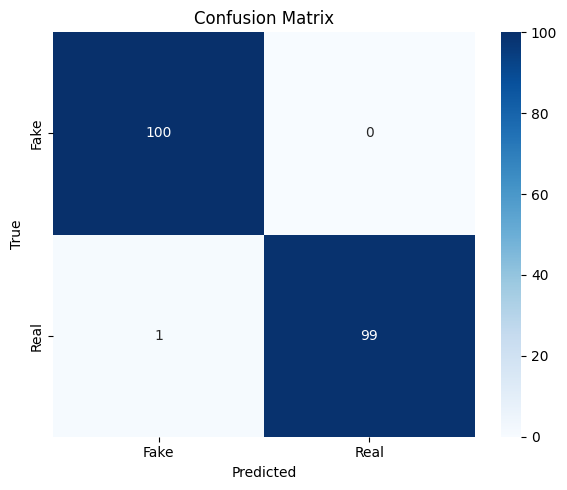

In [8]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


# -----------------------------
# CONFIG
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dir = "C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Aadhaar_Dataset\\Balanced_Data\\test"     # <-- change this
class_names = ["Fake", "Real"]
class_to_idx = {"Fake": 0, "Real": 1}
THRESHOLD = 0.5

# -----------------------------
# TRANSFORM (same as training)
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((572, 572)),   # or your training transform
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# -----------------------------
# LOAD MODEL
# -----------------------------
# model = RealFakeCNN().to(device)
# model = torch.jit.load("detection_model.pt", map_location=torch.device("cpu"))

# model = torch.jit.load("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\Noiseprint_Dataset\\best_model.pth", map_location=device)
model = torch.jit.load("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\detection_model.pt", map_location=device)
model.eval()

# -----------------------------
# INFERENCE
# -----------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for class_name in class_names:
        class_path = os.path.join(test_dir, class_name)
        label = class_to_idx[class_name]

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                img = Image.open(img_path).convert("RGB")
            except:
                continue  # skip unreadable files

            img = transform(img).unsqueeze(0).to(device)  # [1, C, H, W]

            output = model(img)          # [1, 1]
            pred = (output >= THRESHOLD).long().item()
            # print(img_name,' ',pred)
            all_preds.append(pred)
            all_labels.append(label)

# -----------------------------
# CONFUSION MATRIX
# -----------------------------

# acc = accuracy_score(all_labels, all_preds)
# prec = precision_score(all_labels, all_preds)
# rec = recall_score(all_labels, all_preds)
# f1 = f1_score(all_labels, all_preds)

# print("\n================ RESULTS ================\n")
# print(f"Accuracy  : {acc:.4f}")
# print(f"Precision : {prec:.4f}")
# print(f"Recall    : {rec:.4f}")
# print(f"F1 Score  : {f1:.4f}")
print(classification_report(all_labels, all_preds, target_names=["Real", "Forged"]))

# ----------------------------
# CONFUSION MATRIX
# ----------------------------
# cm = confusion_matrix(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Evaluating REAL images...


100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


Evaluating FORGED images...


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]



================ RESULTS ================

Accuracy  : 0.9900
Precision : 0.9900
Recall    : 0.9900
F1 Score  : 0.9900

Confusion Matrix:
[[99  1]
 [ 1 99]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       100
      Forged       0.99      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



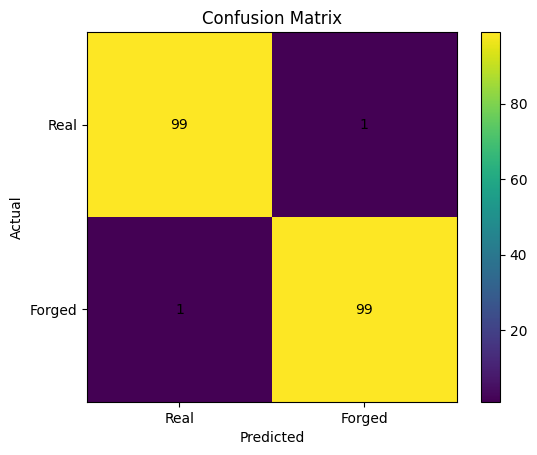

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# ----------------------------
# LOAD MODEL
# ----------------------------
model = YOLO(r"C:\Users\dhruv\Downloads\yolo_runsnew_2\detect\train\weights\best.pt")

# ----------------------------
# DATASET PATH
# ----------------------------
TEST_ROOT = r"C:\Users\dhruv\OneDrive\Desktop\Aadhaar_Detection\Aadhaar_Dataset\Balanced_Data\test"

REAL_DIR = os.path.join(TEST_ROOT, "real")
FORGED_DIR = os.path.join(TEST_ROOT, "fake")

# ----------------------------
# LABELS
# ----------------------------
# 0 = real, 1 = forged
y_true = []
y_pred = []

# ----------------------------
# FUNCTION TO PREDICT ONE IMAGE
# ----------------------------
def predict_image(img_path):
    results = model(img_path, conf=0.25, verbose=False)

    r = results[0]

    # If any detection exists → forged
    if r.boxes is not None and len(r.boxes) > 0:
        return 1   # forged
    else:
        return 0   # real

# ----------------------------
# EVALUATE REAL IMAGES
# ----------------------------
print("Evaluating REAL images...")
for img in tqdm(os.listdir(REAL_DIR)):
    img_path = os.path.join(REAL_DIR, img)

    pred = predict_image(img_path)

    y_true.append(0)   # real
    y_pred.append(pred)

# ----------------------------
# EVALUATE FORGED IMAGES
# ----------------------------
print("Evaluating FORGED images...")
for img in tqdm(os.listdir(FORGED_DIR)):
    img_path = os.path.join(FORGED_DIR, img)

    pred = predict_image(img_path)

    y_true.append(1)   # forged
    y_pred.append(pred)

# ----------------------------
# METRICS
# ----------------------------
y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n================ RESULTS ================\n")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Forged"]))

# ----------------------------
# PLOT CONFUSION MATRIX
# ----------------------------
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Real", "Forged"])
plt.yticks([0,1], ["Real", "Forged"])
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


In [1]:
import torch

model = torch.jit.load("C:\\Users\\dhruv\\OneDrive\\Desktop\\Aadhaar_Detection\\detection_model.pt", map_location="cpu")
print(model)


RecursiveScriptModule(
  original_name=RealFakeCNN
  (model): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=MaxPool2d)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=BatchNorm2d)
    (9): RecursiveScriptModule(original_name=ReLU)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=BatchNorm2d)
    (12): RecursiveScriptModule(original_name=ReLU)
    (13): RecursiveScriptModule(original_name=MaxPool2d)
    (14): RecursiveScriptModule(original_name=Conv2d)
    (15): RecursiveScriptModule(original_name=BatchNorm2d)
    (16):